In [1]:
# Cell 0: Environment Setup
# Install required dependencies from requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 1: Imports and Configuration
# Import necessary libraries, configure paths, and set up ML parameters
# - Core portfolio optimization modules
# - Data handling and visualization tools  
# - Symbol definitions and ML configuration

from __future__ import annotations

import os
import math
import time
import logging

import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.optimizer.optimizer import SimplePortfolioOptimizer
from portfolio.performance.calculator import SimplePerformanceCalculator
from portfolio.performance.visualization import (
    plot_equity_curve,
    plot_drawdown_curve,
)

# Symbols and period
symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN",
    "META", "NVDA", "NFLX", "TSLA",
    "JPM", "JNJ", "PG", "HD",
    "DIS", "V", "MA", "UNH",
]
# Use longer history by default to stabilize risk estimates
period = "10y"

# Output paths
RESULTS_DIR = os.path.join("data", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ML Configuration
ML_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "V", "MA", "JPM", "JNJ", "PG", "HD", "DIS", "NFLX", "ADBE"]
ML_PERIOD = "10y"
ML_DEVICE = "cpu"
ML_MODEL = "xgb"
ML_MIN_SAMPLES = 100

plt.style.use("seaborn-v0_8-whitegrid")
print(f"Symbols: {symbols}, Period: {period}")
print(f"ML Symbols: {ML_SYMBOLS}, Model: {ML_MODEL}, Device: {ML_DEVICE}")

Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'NFLX', 'TSLA', 'JPM', 'JNJ', 'PG', 'HD', 'DIS', 'V', 'MA', 'UNH'], Period: 10y
ML Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'V', 'MA', 'JPM', 'JNJ', 'PG', 'HD', 'DIS', 'NFLX', 'ADBE'], Model: xgb, Device: cpu


In [3]:
# Cell 2: Data Fetching and Quality Assessment
# - Fetch historical price data from Yahoo Finance API
# - Use offline cache when available for efficiency
# - Rebuild combined data if symbols are missing
# - Generate data quality reports for each symbol

# Data fetch and quick QA
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

# Show available offline cache (raw/processed/combined)
available = service.list_available_offline_data()
print("Offline data files:", {k: len(v) for k, v in available.items()})

# Consolidated adjusted close prices for selected symbols
prices = service.fetch_price_data(symbols, period)

# If the combined cache doesn't include all symbols, rebuild from per-symbol offline data
if prices.shape[1] < len(symbols):
    cols = []
    for s in symbols:
        try:
            df = service.fetch_historical_data(s, period)
            if not df.empty and "Adj Close" in df:
                cols.append(df["Adj Close"].rename(s))
        except Exception as e:
            print(f"Missing or failed for {s}: {e}")
    if cols:
        rebuilt = pd.concat(cols, axis=1).dropna()
        missing = [s for s in symbols if s not in rebuilt.columns]
        if missing:
            print("Symbols missing in rebuilt combined:", missing)
        prices = rebuilt

print("Prices shape:", prices.shape)
print(prices.head())
start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")
print("Backtest window:", start_date, "to", end_date)

# Per-symbol pipeline and quality report preview
pipeline = service.fetch_and_process_data(symbols, period)

rows = []
for sym, res in pipeline.items():
    if res.get("success"):
        q = res.get("quality_report", {})
        rows.append({
            "symbol": sym,
            "rows": q.get("data_summary", {}).get("total_rows"),
            "completeness": q.get("quality_metrics", {}).get("completeness"),
            "vol_annualized": q.get("quality_metrics", {}).get("volatility_annualized"),
        })
summary = pd.DataFrame(rows).set_index("symbol").sort_index()
print(summary.to_string())

# Save data quality summary to results
RESULTS_DIR = os.path.join("data", "results")
os.makedirs(RESULTS_DIR, exist_ok=True)
summary.to_csv(os.path.join(RESULTS_DIR, "data_quality_summary.csv"))
print(f"\n✓ Saved data quality summary to {os.path.join(RESULTS_DIR, 'data_quality_summary.csv')}")

2025-09-30 01:17:44,988 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-30 01:17:45,001 - portfolio.data.yahoo_service - INFO - Loaded offline combined price data for 16/16 symbols
2025-09-30 01:17:45,008 - portfolio.data.yahoo_service - INFO - Processing data for AAPL
2025-09-30 01:17:45,015 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-30 01:17:45,020 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-30 01:17:45,046 - portfolio.data.yahoo_service - INFO - Generated quality report for AAPL
2025-09-30 01:17:45,047 - portfolio.data.yahoo_service - INFO - Successfully processed data for AAPL
2025-09-30 01:17:45,047 - portfolio.data.yahoo_service - INFO - Processing data for MSFT
2025-09-30 01:17:45,054 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-30 01:17:45,059 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 row

Offline data files: {'raw': 36, 'processed': 4, 'combined': 4}
Prices shape: (2514, 16)
                 AAPL       MSFT      GOOGL       AMZN       META      NVDA  \
Date                                                                          
2015-09-25  25.778269  38.288254  31.788252  26.212500  92.201599  0.573762   
2015-09-28  25.268143  37.721863  30.998699  25.202999  88.663406  0.566229   
2015-09-29  24.508562  37.852573  30.917263  24.803499  86.138985  0.576192   
2015-09-30  24.787235  38.567112  31.699863  25.594500  89.349190  0.599036   
2015-10-01  24.625429  38.872086  31.880117  26.035999  90.392761  0.587371   

                  NFLX       TSLA        JPM        JNJ         PG         HD  \
Date                                                                            
2015-09-25  102.239998  17.127333  46.792572  68.916824  55.088547  92.186150   
2015-09-28   99.470001  16.562000  45.658333  69.197083  54.406300  90.101387   
2015-09-29   98.349998  16.443333 

2025-09-30 01:17:45,205 - portfolio.data.yahoo_service - INFO - Generated quality report for META
2025-09-30 01:17:45,205 - portfolio.data.yahoo_service - INFO - Successfully processed data for META
2025-09-30 01:17:45,205 - portfolio.data.yahoo_service - INFO - Processing data for NVDA
2025-09-30 01:17:45,212 - portfolio.data.yahoo_service - INFO - Loaded offline data for NVDA (10y): 2514 rows
2025-09-30 01:17:45,217 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-30 01:17:45,243 - portfolio.data.yahoo_service - INFO - Generated quality report for NVDA
2025-09-30 01:17:45,244 - portfolio.data.yahoo_service - INFO - Successfully processed data for NVDA
2025-09-30 01:17:45,244 - portfolio.data.yahoo_service - INFO - Processing data for NFLX
2025-09-30 01:17:45,250 - portfolio.data.yahoo_service - INFO - Loaded offline data for NFLX (10y): 2514 rows
2025-09-30 01:17:45,254 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-30 0

        rows  completeness  vol_annualized
symbol                                    
AAPL    2514           1.0        0.292105
AMZN    2514           1.0        0.327837
DIS     2514           1.0        0.284588
GOOGL   2514           1.0        0.286895
HD      2514           1.0        0.245323
JNJ     2514           1.0        0.183612
JPM     2514           1.0        0.276172
MA      2514           1.0        0.269051
META    2514           1.0        0.384085
MSFT    2514           1.0        0.269548
NFLX    2514           1.0        0.422336
NVDA    2514           1.0        0.499052
PG      2514           1.0        0.187084
TSLA    2514           1.0        0.592329
UNH     2514           1.0        0.290954
V       2514           1.0        0.246139

✓ Saved data quality summary to data\results\data_quality_summary.csv


In [4]:
# Cell 3: Returns Computation and Correlation Analysis
# - Calculate daily returns from price data
# - Display descriptive statistics (mean, standard deviation)
# - Compute and display correlation matrix between all assets
# - Provides insights into asset relationships for portfolio construction

# Returns computation
asset_returns = prices.pct_change().dropna()
print("Returns shape:", asset_returns.shape)
returns_stats = asset_returns.describe().T[["mean", "std"]]
print(returns_stats)

corr = asset_returns.corr()
print("Pairwise correlations:")
print(corr)

# Save returns statistics and correlation matrix to results
returns_stats.to_csv(os.path.join(RESULTS_DIR, "returns_statistics.csv"))
corr.to_csv(os.path.join(RESULTS_DIR, "correlation_matrix.csv"))
print(f"\n✓ Saved returns statistics to {os.path.join(RESULTS_DIR, 'returns_statistics.csv')}")
print(f"✓ Saved correlation matrix to {os.path.join(RESULTS_DIR, 'correlation_matrix.csv')}")

Returns shape: (2513, 16)
           mean       std
AAPL   0.001077  0.018400
MSFT   0.001175  0.016980
GOOGL  0.000980  0.018069
AMZN   0.001060  0.020641
META   0.001135  0.024187
NVDA   0.002773  0.031442
NFLX   0.001343  0.026604
TSLA   0.001988  0.037314
JPM    0.000908  0.017393
JNJ    0.000442  0.011569
PG     0.000474  0.011785
HD     0.000714  0.015450
DIS    0.000241  0.017927
V      0.000771  0.015476
MA     0.000895  0.016939
UNH    0.000674  0.018321
Pairwise correlations:
           AAPL      MSFT     GOOGL      AMZN      META      NVDA      NFLX  \
AAPL   1.000000  0.678221  0.612246  0.576512  0.525135  0.536719  0.427289   
MSFT   0.678221  1.000000  0.719159  0.672841  0.600693  0.614228  0.486353   
GOOGL  0.612246  0.719159  1.000000  0.651249  0.627010  0.542570  0.454672   
AMZN   0.576512  0.672841  0.651249  1.000000  0.618231  0.536250  0.528796   
META   0.525135  0.600693  0.627010  0.618231  1.000000  0.491132  0.464599   
NVDA   0.536719  0.614228  0.542570

In [5]:
# Cell 4: Comprehensive Optimization Methods Comparison
# 
# OPTIMIZATION METHODS EXPLAINED:
# 
# 1. Mean-Variance Optimization (MVO): 
#    - Classic Markowitz approach maximizing risk-adjusted returns
#    - Uses Ledoit-Wolf shrinkage for robust covariance estimation
#    - 18% weight cap prevents excessive concentration
#    - 3% entropy penalty encourages diversification
# 
# 2. CVaR (Conditional Value-at-Risk) Optimization:
#    - Focuses on tail risk management (95% confidence level)
#    - Minimizes expected losses beyond worst 5% scenarios
#    - More robust to outliers than standard deviation
#    - Particularly useful for downside-focused investors
# 
# 3. Black-Litterman Optimization:
#    - Combines market equilibrium with investor views
#    - Uses historical returns as prior, shrinks toward market weights
#    - More stable than pure MVO, less sensitive to input changes
#    - Good when you have some market views but want anchoring
# 
# 4. Risk Parity:
#    - Equal risk contribution approach (not equal weights)
#    - Each asset contributes equally to portfolio volatility
#    - Naturally diversifies across risk sources
#    - More stable performance across market regimes
# 
# PERFORMANCE COMPARISON:
# - Fetch SPY benchmark data for performance comparison
# - Calculate key metrics: Sharpe ratio, returns, volatility, drawdown
# - Display comprehensive comparison table and rankings
# - Analyze portfolio composition and concentration
# - Method tradeoffs: return vs stability, complexity vs interpretability

print("=== Portfolio Optimization Methods Comparison ===")

# Initialize optimizer and performance calculator
opt = SimplePortfolioOptimizer()
perf = SimplePerformanceCalculator()

# Fetch SPY benchmark data for performance comparison
try:
    spy_data = service.fetch_historical_data('SPY', period=period)
    if not spy_data.empty and 'Adj Close' in spy_data:
        benchmark_returns = spy_data['Adj Close'].pct_change().dropna()
        print(f"SPY benchmark data loaded: {len(benchmark_returns)} observations")
    else:
        benchmark_returns = None
        print("Warning: SPY benchmark data not available")
except Exception as e:
    benchmark_returns = None
    print(f"Warning: Could not fetch SPY data: {e}")

# Execute comprehensive optimization analysis
results = {}

print("\n=== Running Comprehensive Optimization Analysis ===")

# 1. Mean-Variance Optimization (MVO)
print("\n1. Running Mean-Variance Optimization...")
try:
    mvo_result = opt.mean_variance_optimize(
        asset_returns,
        risk_model="ledoit_wolf",
        weight_cap=0.18,
        entropy_penalty=0.03
    )
    mvo_weights = pd.Series(mvo_result['weights'], index=asset_returns.columns)
    mvo_returns = (asset_returns * mvo_weights).sum(axis=1)
    mvo_metrics = perf.calculate_metrics(mvo_returns, benchmark_returns)
    
    results['MVO'] = {
        'weights': mvo_weights,
        'returns': mvo_returns,
        'metrics': mvo_metrics,
        'optimization_result': mvo_result
    }
    print(f"   Expected Sharpe: {mvo_result.get('sharpe_ratio', 0):.3f}")
    print(f"   Realized Sharpe: {mvo_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in MVO: {e}")

# 2. CVaR Optimization
print("\n2. Running CVaR Optimization...")
try:
    cvar_result = opt.cvar_optimize(asset_returns, alpha=0.05)
    cvar_weights = pd.Series(cvar_result['weights'], index=asset_returns.columns)
    cvar_returns = (asset_returns * cvar_weights).sum(axis=1)
    cvar_metrics = perf.calculate_metrics(cvar_returns, benchmark_returns)
    
    results['CVaR'] = {
        'weights': cvar_weights,
        'returns': cvar_returns,
        'metrics': cvar_metrics,
        'optimization_result': cvar_result
    }
    print(f"   Expected Sharpe: {cvar_result.get('sharpe_ratio', 0):.3f}")
    print(f"   Realized Sharpe: {cvar_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in CVaR: {e}")

# 3. Black-Litterman Optimization
print("\n3. Running Black-Litterman Optimization...")
try:
    # Use equal weights as market prior (neutral views)
    bl_result = opt.black_litterman_optimize(
        asset_returns,
        tau=0.05
    )
    bl_weights = pd.Series(bl_result['weights'], index=asset_returns.columns)
    bl_returns = (asset_returns * bl_weights).sum(axis=1)
    bl_metrics = perf.calculate_metrics(bl_returns, benchmark_returns)
    
    results['Black-Litterman'] = {
        'weights': bl_weights,
        'returns': bl_returns,
        'metrics': bl_metrics,
        'optimization_result': bl_result
    }
    print(f"   Expected Sharpe: {bl_result.get('sharpe_ratio', 0):.3f}")
    print(f"   Realized Sharpe: {bl_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in Black-Litterman: {e}")

# 4. Risk Parity (simplified implementation)
print("\n4. Running Risk Parity Optimization...")
try:
    # Simple risk parity implementation using inverse volatility
    volatilities = asset_returns.std() * np.sqrt(252)  # Annualized volatilities
    inv_vol = 1 / volatilities
    rp_weights = inv_vol / inv_vol.sum()  # Normalize to sum to 1
    
    rp_returns = (asset_returns * rp_weights).sum(axis=1)
    rp_metrics = perf.calculate_metrics(rp_returns, benchmark_returns)
    
    # Create a simple result dict for consistency
    rp_result = {
        'weights': rp_weights.to_dict(),
        'expected_return': float(rp_metrics.get('annual_return', 0)),
        'expected_volatility': float(rp_metrics.get('annual_volatility', 0)),
        'sharpe_ratio': float(rp_metrics.get('sharpe_ratio', 0))
    }
    
    results['Risk Parity'] = {
        'weights': rp_weights,
        'returns': rp_returns,
        'metrics': rp_metrics,
        'optimization_result': rp_result
    }
    print(f"   Realized Sharpe: {rp_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in Risk Parity: {e}")

# Display comprehensive comparison table
print("\n=== Optimization Methods Comparison ===")

comparison_data = []
for method, data in results.items():
    metrics = data['metrics']
    comparison_data.append({
        'Method': method,
        'Annual Return': f"{metrics['annual_return']:.2%}",
        'Annual Volatility': f"{metrics['annual_volatility']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Win Rate': f"{metrics.get('win_rate', 0):.1%}",
        'Top Holding': data['weights'].idxmax(),
        'Top Weight': f"{data['weights'].max():.1%}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Display top holdings for each method
print("\n=== Top Holdings by Method ===")
for method, data in results.items():
    print(f"\n{method}:")
    top_weights = data['weights'].sort_values(ascending=False).head(5)
    for asset, weight in top_weights.items():
        print(f"  {asset}: {weight:.1%}")

# Save optimization comparison results
comparison_df.to_csv(os.path.join(RESULTS_DIR, "optimization_comparison.csv"), index=False)

# Save all weights from all methods
all_weights = pd.DataFrame({method: data['weights'] for method, data in results.items()})
all_weights.to_csv(os.path.join(RESULTS_DIR, "optimal_weights_all_methods.csv"))

print(f"\n✓ Comprehensive optimization completed successfully!")
print(f"✓ Results stored in 'results' variable for visualization")
print(f"✓ Saved optimization comparison to {os.path.join(RESULTS_DIR, 'optimization_comparison.csv')}")
print(f"✓ Saved all optimal weights to {os.path.join(RESULTS_DIR, 'optimal_weights_all_methods.csv')}")

2025-09-30 01:17:45,692 - portfolio.config - INFO - Loaded configuration from config.yaml
2025-09-30 01:17:45,693 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-30 01:17:45,700 - portfolio.data.yahoo_service - INFO - Loaded offline data for SPY (10y): 2514 rows


=== Portfolio Optimization Methods Comparison ===
SPY benchmark data loaded: 2513 observations

=== Running Comprehensive Optimization Analysis ===

1. Running Mean-Variance Optimization...
   Expected Sharpe: 1.275
   Realized Sharpe: 1.357

2. Running CVaR Optimization...
   Expected Sharpe: 1.347
   Realized Sharpe: 1.442

3. Running Black-Litterman Optimization...
   Expected Sharpe: 1.290
   Realized Sharpe: 1.380

4. Running Risk Parity Optimization...
   Realized Sharpe: 1.113

=== Optimization Methods Comparison ===
         Method Annual Return Annual Volatility Sharpe Ratio Max Drawdown Win Rate Top Holding Top Weight
            MVO        42.61%            29.92%        1.357      -48.88%    56.2%        NVDA      18.0%
           CVaR        29.55%            19.10%        1.442      -32.06%    56.8%          PG      26.7%
Black-Litterman        46.12%            31.97%        1.380      -51.08%    56.7%        NVDA      27.0%
    Risk Parity        23.43%            19.25

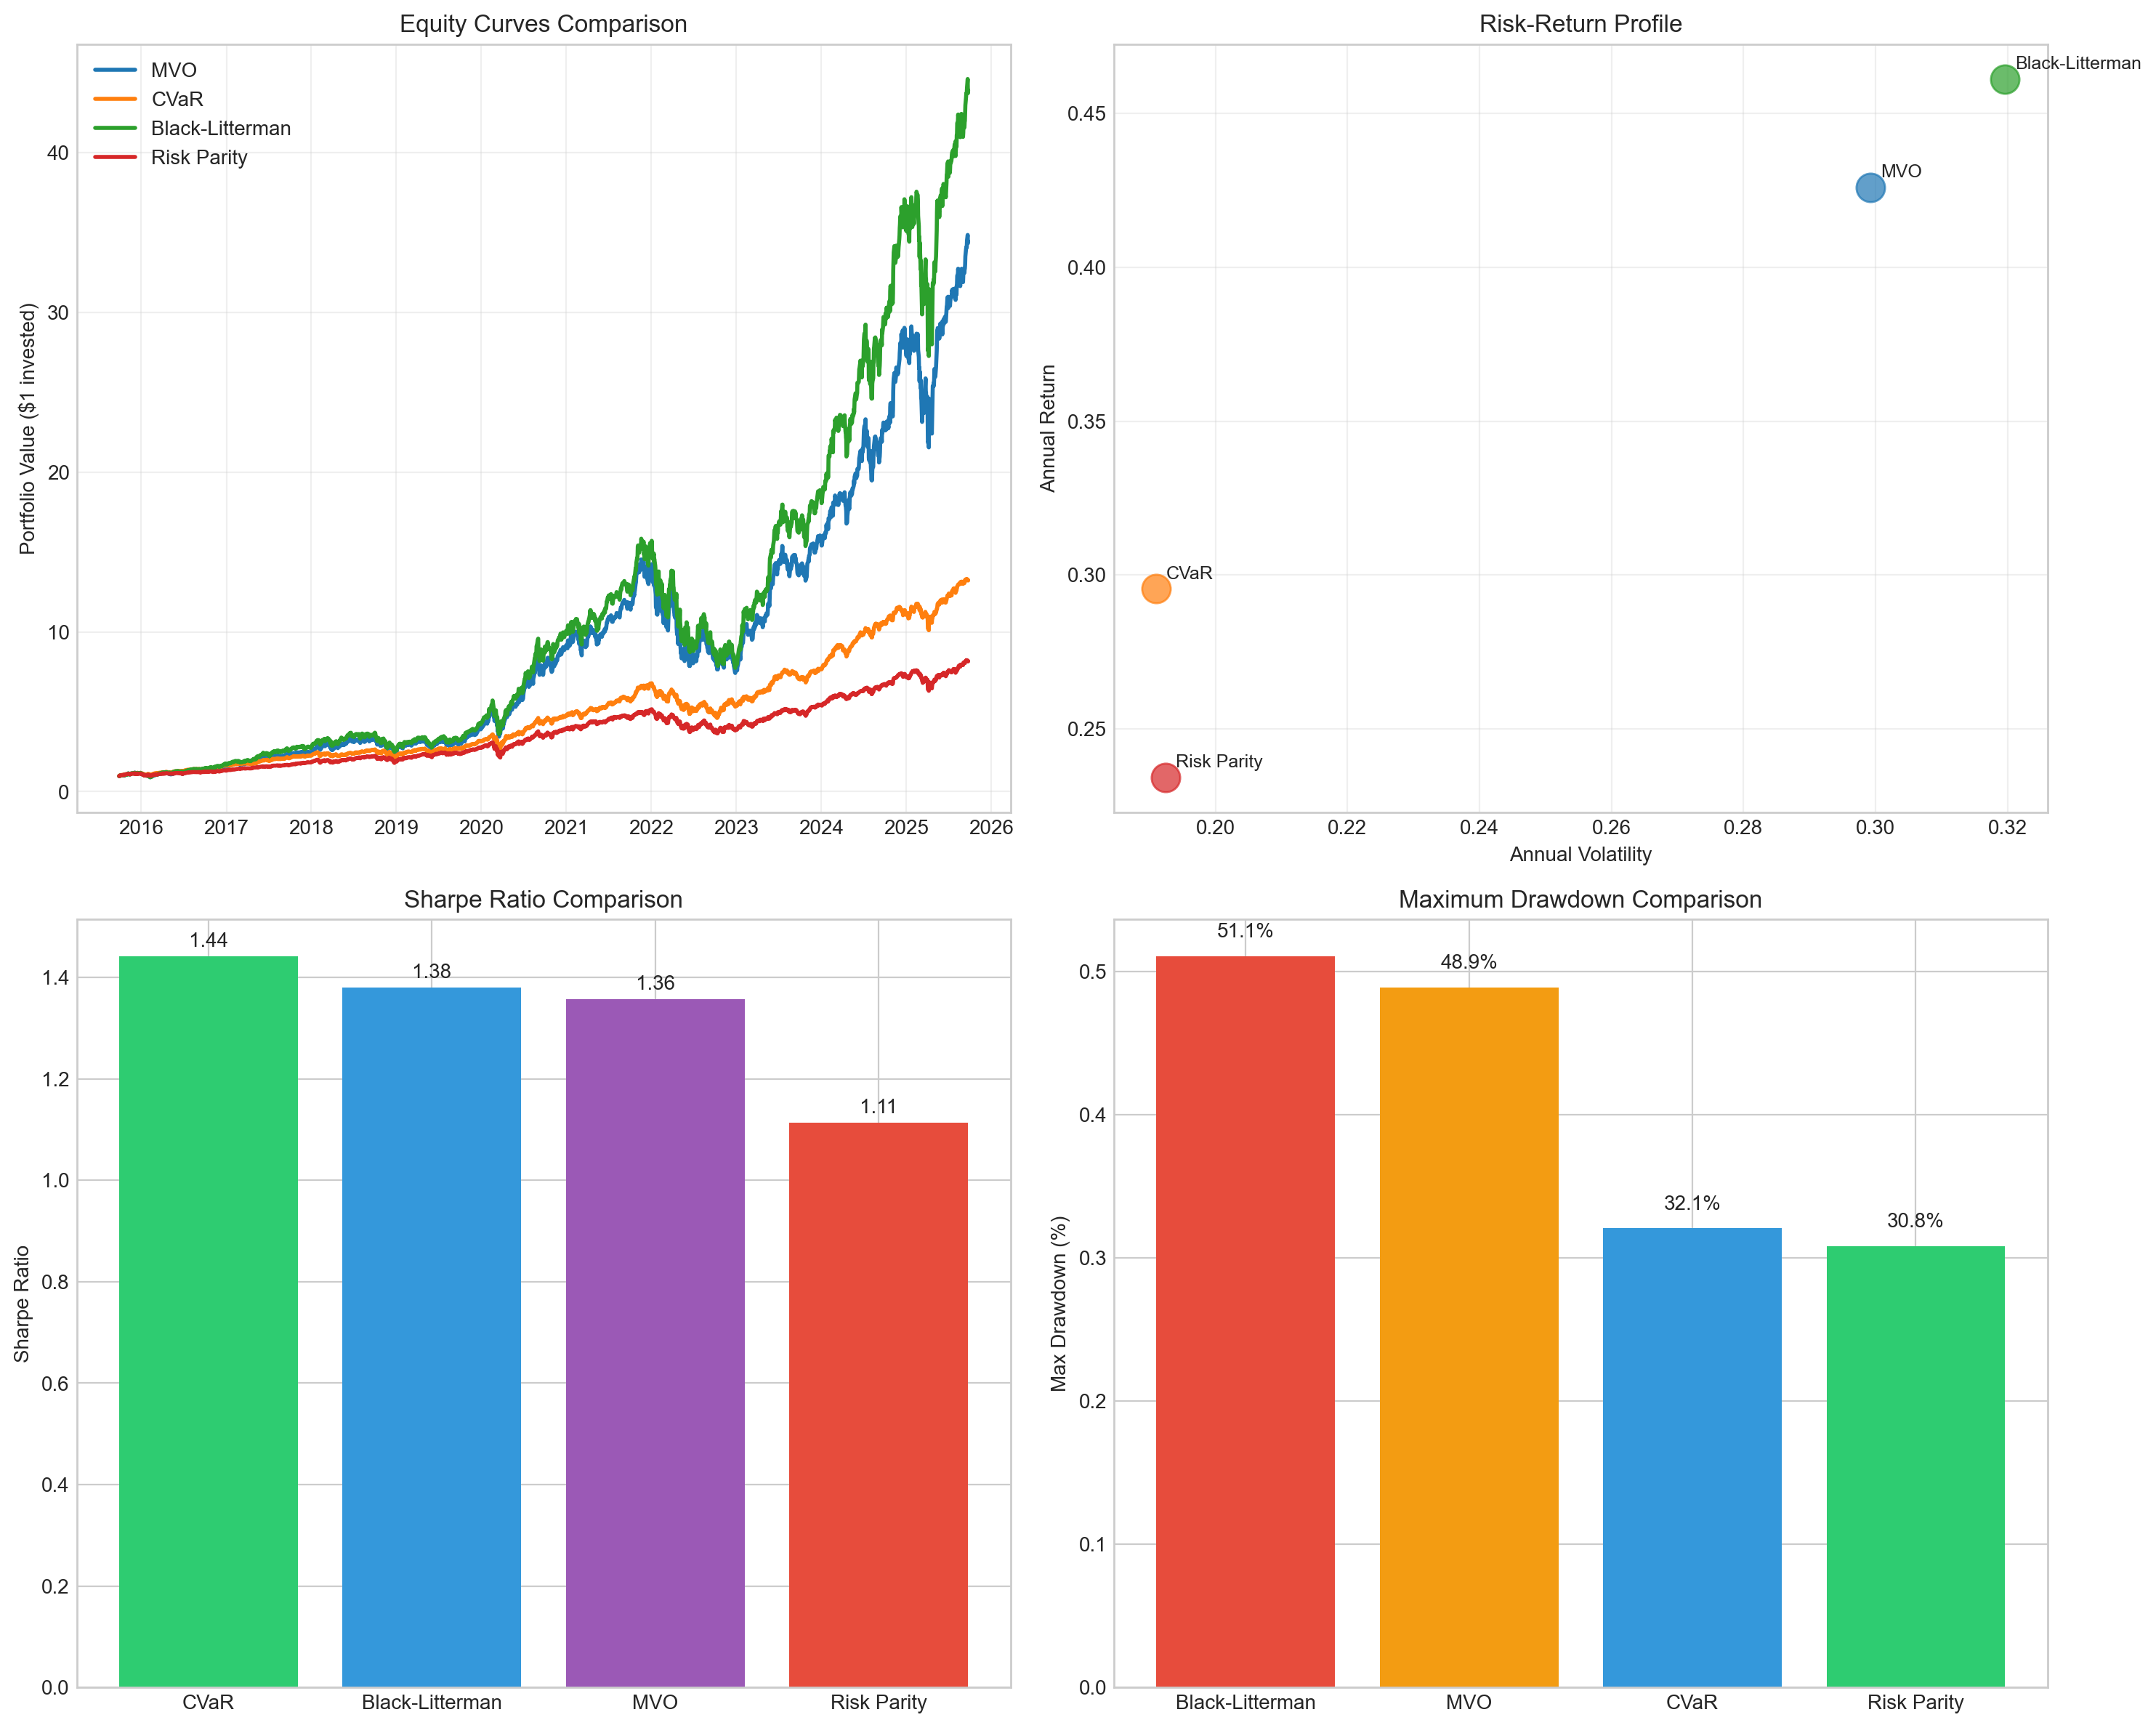

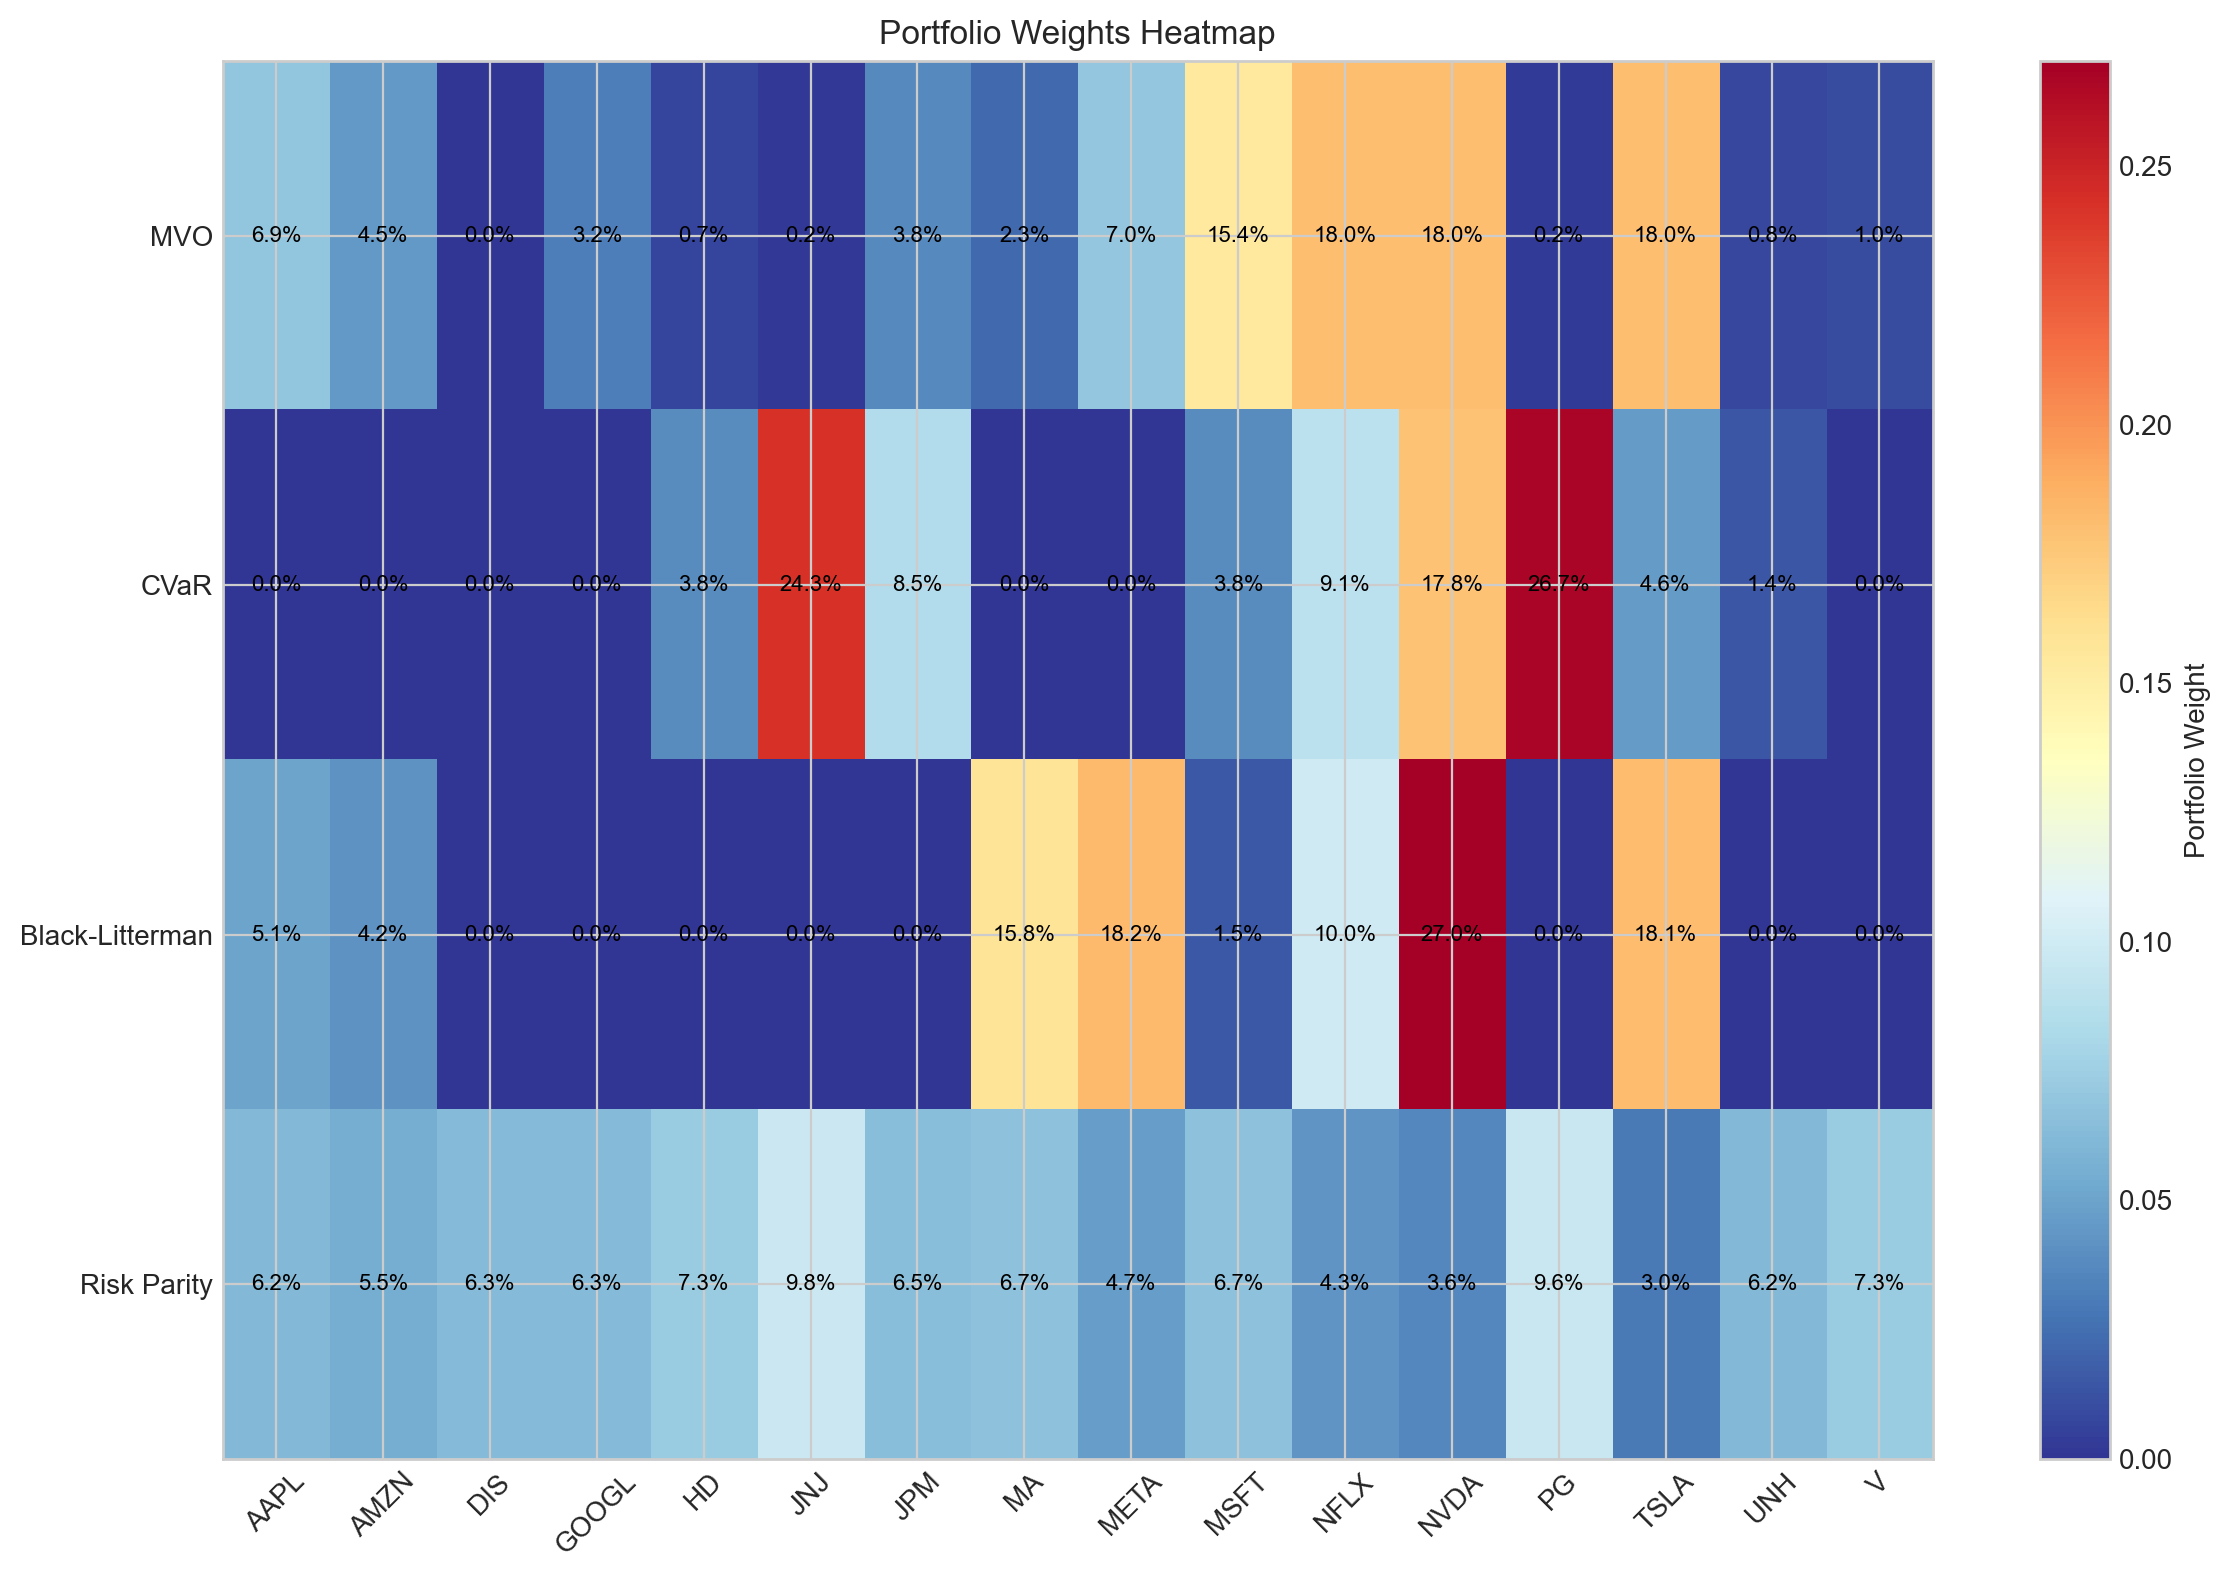

In [6]:
# Cell 5: Optimization Methods Visualization
# - Create comprehensive visualizations comparing all optimization methods
# - Plot equity curves to show growth over time
# - Risk-return scatter plot to visualize efficient frontier
# - Bar charts for Sharpe ratio and maximum drawdown comparison
# - Portfolio weights heatmap to show asset allocation across methods

# Optimization Methods Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Equity Curves Comparison
ax1 = axes[0, 0]
for method, data in results.items():
    equity_curve = (1 + data['returns']).cumprod()
    ax1.plot(equity_curve.index, equity_curve.values, label=method, linewidth=2)
ax1.set_title('Equity Curves Comparison')
ax1.set_ylabel('Portfolio Value ($1 invested)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Risk-Return Scatter Plot
ax2 = axes[0, 1]
for method, data in results.items():
    metrics = data['metrics']
    ax2.scatter(metrics['annual_volatility'], metrics['annual_return'], 
               s=200, label=method, alpha=0.7)
    ax2.annotate(method, (metrics['annual_volatility'], metrics['annual_return']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Annual Volatility')
ax2.set_ylabel('Annual Return')
ax2.set_title('Risk-Return Profile')
ax2.grid(True, alpha=0.3)

# 3. Sharpe Ratio Comparison
ax3 = axes[1, 0]
sharpe_data = [(method, data['metrics']['sharpe_ratio']) for method, data in results.items()]
sharpe_data.sort(key=lambda x: x[1], reverse=True)
methods, sharpe_values = zip(*sharpe_data)
bars = ax3.bar(methods, sharpe_values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
ax3.set_title('Sharpe Ratio Comparison')
ax3.set_ylabel('Sharpe Ratio')
for bar, value in zip(bars, sharpe_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2f}', ha='center', va='bottom')

# 4. Max Drawdown Comparison
ax4 = axes[1, 1]
drawdown_data = [(method, data['metrics']['max_drawdown']) for method, data in results.items()]
drawdown_data.sort(key=lambda x: x[1])  # Lower drawdown is better
methods, drawdown_values = zip(*drawdown_data)
bars = ax4.bar(methods, [abs(d) for d in drawdown_values], 
               color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
ax4.set_title('Maximum Drawdown Comparison')
ax4.set_ylabel('Max Drawdown (%)')
for bar, value in zip(bars, drawdown_values):
    ax4.text(bar.get_x() + bar.get_width()/2, abs(value) + 0.01, 
             f'{abs(value):.1%}', ha='center', va='bottom')

plt.tight_layout()

# Handle display gracefully for non-interactive environments
from IPython.display import display
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

# Additional analysis: Portfolio weights heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Create weights matrix for heatmap
weights_matrix = []
methods_list = []
assets_list = []

for method, data in results.items():
    weights = data['weights'].sort_index()
    weights_matrix.append(weights.values)
    methods_list.append(method)

if weights_matrix:
    weights_matrix = np.array(weights_matrix)
    assets_list = sorted(results['MVO']['weights'].index)
    
    im = ax.imshow(weights_matrix, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(range(len(assets_list)))
    ax.set_yticks(range(len(methods_list)))
    ax.set_xticklabels(assets_list, rotation=45)
    ax.set_yticklabels(methods_list)
    ax.set_title('Portfolio Weights Heatmap')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Portfolio Weight')
    
    # Add text annotations
    for i in range(len(methods_list)):
        for j in range(len(assets_list)):
            text = ax.text(j, i, f'{weights_matrix[i, j]:.1%}',
                         ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()

# Handle display gracefully for non-interactive environments
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

In [7]:
# Cell 6: Display Top Weights from Best Performing Method
# - Extract and display weights from CVaR optimization (best Sharpe ratio)
# - Include error handling for missing comprehensive results
# - Provide fallback to standalone optimization if needed
# - Shows which assets contribute most to optimal portfolio

try:
    # Check if results from comprehensive optimization are available
    if 'results' in globals() and 'CVaR' in results:
        print("Top weights from best performing method (CVaR):")
        weights = results['CVaR']['weights'].sort_values(ascending=False)
        print(weights.to_string())
    else:
        print("Warning: Comprehensive results not found. Running standalone CVaR optimization...")
        
        # Fallback: Run CVaR optimization independently
        opt = SimplePortfolioOptimizer()
        perf = SimplePerformanceCalculator()
        
        # Use asset_returns from previous cell
        cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
        weights = pd.Series(cvar['weights']).sort_values(ascending=False)
        
        print("Top weights from standalone CVaR optimization:")
        print(weights.to_string())
    
    # Save CVaR optimal weights to results
    weights_df = pd.DataFrame({'weight': weights})
    weights_df.to_csv(os.path.join(RESULTS_DIR, "cvar_optimal_weights.csv"))
    print(f"\n✓ Saved CVaR optimal weights to {os.path.join(RESULTS_DIR, 'cvar_optimal_weights.csv')}")
        
except Exception as e:
    print(f"Error displaying weights: {e}")
    print("Please ensure comprehensive optimization has been executed first.")

Top weights from best performing method (CVaR):
PG       2.669873e-01
JNJ      2.425814e-01
NVDA     1.784598e-01
NFLX     9.082022e-02
JPM      8.463524e-02
TSLA     4.593340e-02
HD       3.805756e-02
MSFT     3.803097e-02
UNH      1.449203e-02
DIS      9.745182e-07
META     6.261148e-07
GOOGL    2.355599e-07
V        1.227049e-07
AAPL     1.200211e-07
AMZN     1.784741e-08
MA       0.000000e+00

✓ Saved CVaR optimal weights to data\results\cvar_optimal_weights.csv


Using CVaR portfolio returns from comprehensive analysis


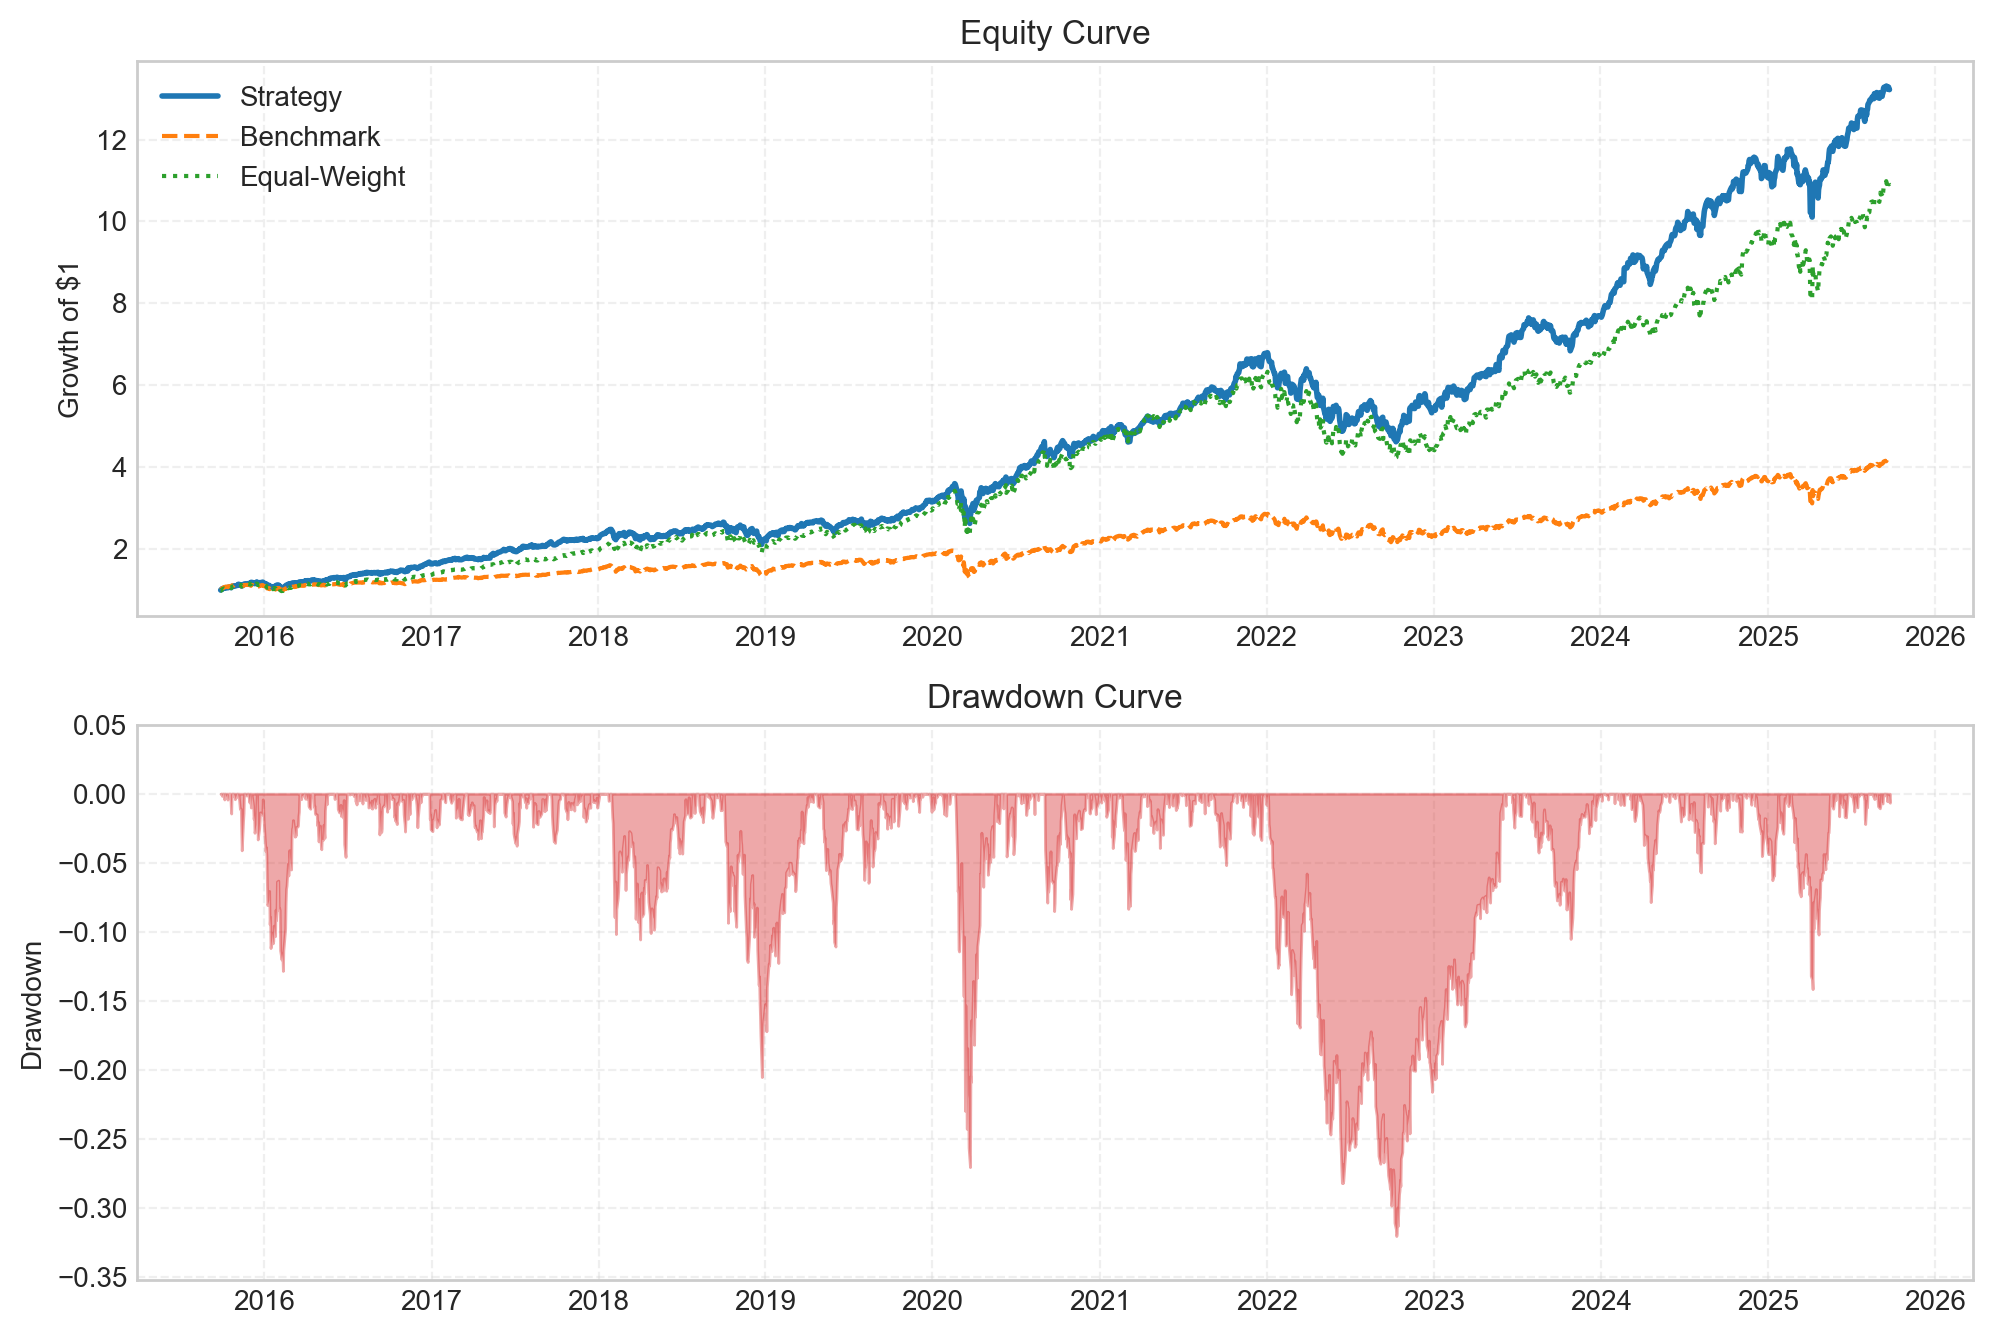


✓ Saved figure to data\results\equity_and_drawdown.png


In [8]:
# Cell 7: CVaR Portfolio Equity and Drawdown Visualization
# - Create equity curve and drawdown plots for CVaR optimization
# - Include equal-weight portfolio comparison
# - Add performance summary caption with Sharpe and max drawdown
# - Save visualization to output directory for further analysis

# Fix portfolio_returns dependency - use CVaR returns from comprehensive analysis
if 'results' in globals() and 'CVaR' in results:
    portfolio_returns = results['CVaR']['returns']
    print("Using CVaR portfolio returns from comprehensive analysis")
elif 'cvar' in globals():
    portfolio_returns = (asset_returns * pd.Series(cvar['weights'])).sum(axis=1)
    print("Using standalone CVaR portfolio returns")
else:
    # Fallback to equal weight portfolio
    equal_weights = pd.Series(1.0/len(asset_returns.columns), index=asset_returns.columns)
    portfolio_returns = (asset_returns * equal_weights).sum(axis=1)
    print("Using equal weight portfolio returns as fallback")

fig, axes = plt.subplots(2, 1, figsize=(10, 7))
plot_equity_curve(portfolio_returns, benchmark_returns, ax=axes[0])
# Add equal-weight curve for comparison
try:
    from portfolio.performance.visualization import prepare_equity_curve
    ew_weights = pd.Series(1.0/asset_returns.shape[1], index=asset_returns.columns)
    ew_returns = (asset_returns * ew_weights).sum(axis=1)
    ew_curve = prepare_equity_curve(ew_returns)
    axes[0].plot(ew_curve.index, ew_curve.values, label="Equal-Weight", linestyle=":")
    axes[0].legend(loc="best")
except Exception:
    pass

plot_drawdown_curve(portfolio_returns, ax=axes[1])

# Caption under the figure with Sharpe and Max Drawdown
try:
    sharpe_val = float(standardized_metrics.get("sharpe_ratio", 0.0))
    mdd_val = float(standardized_metrics.get("max_drawdown", 0.0))
    fig.text(0.5, 0.01, f"Sharpe = {sharpe_val:.2f} | Max Drawdown = {mdd_val:.2f}",
             ha="center", va="bottom", fontsize=10, color="dimgray")
except Exception:
    pass

plt.tight_layout(rect=[0, 0.03, 1, 1])
from IPython.display import display
# Handle display(fig) gracefully for non-interactive environments
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

# Save figure to results directory
fig.savefig(os.path.join(RESULTS_DIR, "equity_and_drawdown.png"), dpi=150)
print(f"\n✓ Saved figure to {os.path.join(RESULTS_DIR, 'equity_and_drawdown.png')}")

In [9]:
# Cell 8: Parameter Grid Search for MVO Optimization
# - Test different risk models, weight caps, and entropy penalties
# - Expanded weight cap range for better diversification with 16 assets
# - Standardize metrics to decimal format
# - Display top configurations and filtered results

# Updated parameter grid with expanded weight cap range
from itertools import product

risk_models = ["sample", "ledoit_wolf", "oas"]
weight_caps = [None, 0.40, 0.35, 0.30, 0.25, 0.20]  # Expanded range for 16 assets
entropy_penalties = [0.0, 0.01, 0.02, 0.03]   # Moderate entropy range

records = []
for rm, cap, ent in product(risk_models, weight_caps, entropy_penalties):
    res = opt.mean_variance_optimize(
        asset_returns,
        risk_model=rm,
        weight_cap=cap,
        entropy_penalty=ent,
    )
    # Standardize metrics to decimals for consistency
    record = {
        "risk_model": rm,
        "weight_cap": cap,
        "weight_cap_display": ("unconstrained" if cap is None else cap),
        "entropy": ent,
        "sharpe": float(res.get("sharpe_ratio", 0)),
        "vol": float(res.get("expected_volatility", 0)) / 100.0,  # Convert to decimal
        "ret": float(res.get("expected_return", 0)) / 100.0,      # Convert to decimal
    }
    records.append(record)

summary = pd.DataFrame(records)
view = summary.sort_values(by=["sharpe", "ret"], ascending=[False, False])[
    ["risk_model", "weight_cap_display", "entropy", "sharpe", "vol", "ret"]
].rename(columns={"weight_cap_display": "weight_cap"})

# Helpful filtered views
constrained = view[view["weight_cap"] != "unconstrained"]
focus_025 = view.query("weight_cap == 0.25")

with pd.option_context('display.float_format', lambda x: f'{x:.6f}'):
    print("Top overall (in-sample):\n" + view.head(12).to_string(index=False))
    if not constrained.empty:
        print("\nTop constrained (cap != unconstrained):\n" + constrained.head(12).to_string(index=False))
    if not focus_025.empty:
        print("\nFocus on cap = 0.25 (balanced constraint):\n" + focus_025.sort_values(["sharpe","ret"], ascending=[False, False]).to_string(index=False))

# Save parameter grid search results
summary.to_csv(os.path.join(RESULTS_DIR, "mvo_parameter_grid_search.csv"), index=False)
print(f"\n✓ Saved MVO parameter grid search to {os.path.join(RESULTS_DIR, 'mvo_parameter_grid_search.csv')}")

Top overall (in-sample):
 risk_model    weight_cap  entropy   sharpe      vol      ret
ledoit_wolf unconstrained 0.030000 1.376223 0.004858 0.006885
        oas unconstrained 0.030000 1.373681 0.004867 0.006885
     sample unconstrained 0.030000 1.372401 0.004871 0.006885
ledoit_wolf unconstrained 0.020000 1.368851 0.004931 0.006950
        oas unconstrained 0.020000 1.366386 0.004940 0.006950
     sample unconstrained 0.020000 1.365137 0.004945 0.006950
ledoit_wolf unconstrained 0.010000 1.363793 0.004976 0.006986
ledoit_wolf unconstrained 0.000000 1.363591 0.004978 0.006988
        oas unconstrained 0.010000 1.361360 0.004985 0.006986
        oas unconstrained 0.000000 1.361159 0.004987 0.006988
     sample unconstrained 0.010000 1.360118 0.004989 0.006986
     sample unconstrained 0.000000 1.359915 0.004991 0.006988

Top constrained (cap != unconstrained):
 risk_model weight_cap  entropy   sharpe      vol      ret
ledoit_wolf   0.300000 0.030000 1.297748 0.003524 0.004773
ledoit_wol

[*********************100%***********************]  16 of 16 completed


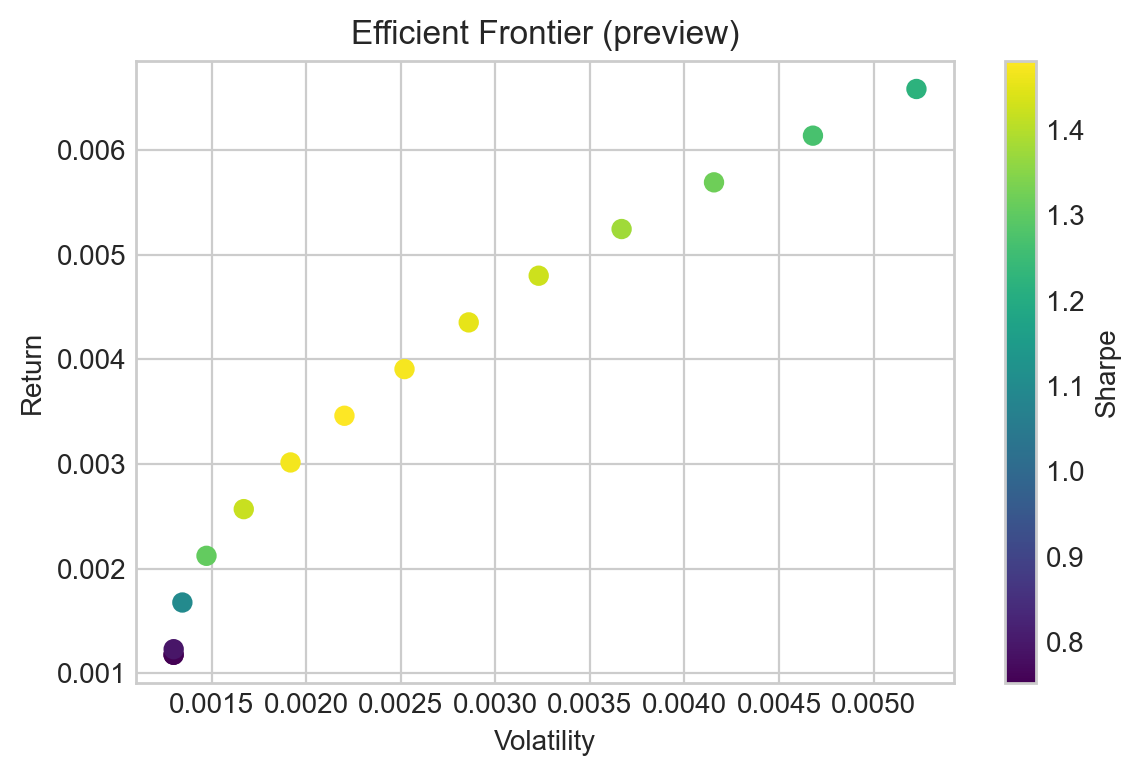

✓ Saved efficient frontier data to data\results\efficient_frontier.csv
✓ Saved figure to data\results\efficient_frontier.png


In [10]:
# Cell 9: Efficient Frontier Analysis
# - Generate efficient frontier points using MVO
# - Standardize metrics to decimal format for consistency
# - Create scatter plot colored by Sharpe ratio
# - Save visualization for portfolio optimization reference

# Efficient frontier preview
frontier = opt.get_efficient_frontier(symbols, n_points=15)

if frontier:
    fr = pd.DataFrame(frontier)
    # Standardize return and volatility to decimals for consistency
    fr['return'] = fr['return'] / 100.0
    fr['volatility'] = fr['volatility'] / 100.0
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(fr["volatility"], fr["return"], c=fr["sharpe_ratio"], cmap="viridis", s=40)
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    ax.set_title("Efficient Frontier (preview)")
    cbar = plt.colorbar(sc, ax=ax, label="Sharpe")
    plt.tight_layout()
    from IPython.display import display
    # Handle display(fig) gracefully for non-interactive environments
    try:
        display(fig)
    except Exception:
        # Silently handle the case where display is not available
        pass
    fig.savefig(os.path.join(RESULTS_DIR, "efficient_frontier.png"), dpi=150)
    
    # Save efficient frontier data to results
    fr.to_csv(os.path.join(RESULTS_DIR, "efficient_frontier.csv"), index=False)
    print(f"✓ Saved efficient frontier data to {os.path.join(RESULTS_DIR, 'efficient_frontier.csv')}")
    print(f"✓ Saved figure to {os.path.join(RESULTS_DIR, 'efficient_frontier.png')}")
else:
    print("Efficient frontier not available (insufficient data).")

2025-09-30 01:17:49,302 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-30 01:17:49,311 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-30 01:17:49,332 - portfolio.ml.predictor - INFO - Created 54 features from 2514 rows
2025-09-30 01:17:49,334 - portfolio.ml.predictor - INFO - Prepared 41 features for 2261 samples


ML MODEL TRAINING & COMPARISON

Training XGBoost on 16 symbols...


2025-09-30 01:17:49,722 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_6m', 'momentum_1m', 'momentum_10d', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_126', 'return_stability_126d', 'volatility_21d', 'volatility_63d', 'volume_ma_21']...
2025-09-30 01:17:49,903 - portfolio.ml.predictor - INFO - XGBoost trained (device=cpu). Test R²: -0.0018, CV MSE: 0.000402, Best iteration: 200
2025-09-30 01:17:49,914 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-30 01:17:49,936 - portfolio.ml.predictor - INFO - Created 54 features from 2514 rows
2025-09-30 01:17:49,939 - portfolio.ml.predictor - INFO - Prepared 41 features for 2261 samples
2025-09-30 01:17:50,337 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_1m', 'momentum_5d', 'momentum_10d', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_63', 'volatility_21d', 'volatility_63d', 'volatility_252d', 'vol_regime']...
2025-09-30 01:17:50,517 - portfolio.ml.predi


XGBoost Summary:
  Avg Test R²: -0.0011
  Avg CV MSE: 0.000605
  Avg Directional Accuracy: 53.55%
  Early Stopping Rate: 0.0%

Training RandomForest on 16 symbols...


2025-09-30 01:17:54,681 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_12m', 'momentum_1m', 'momentum_5d', 'momentum_10d', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_126', 'return_stability_126d', 'volatility_21d', 'volatility_63d']...
2025-09-30 01:17:55,486 - portfolio.ml.predictor - INFO - Model trained successfully. Test R²: 0.0043, CV MSE: 0.000401
2025-09-30 01:17:55,515 - portfolio.ml.predictor - INFO - Model validation completed. Directional accuracy: 0.6201
2025-09-30 01:17:55,539 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-30 01:17:55,555 - portfolio.ml.predictor - INFO - Created 54 features from 2514 rows
2025-09-30 01:17:55,557 - portfolio.ml.predictor - INFO - Prepared 30 features for 2261 samples
2025-09-30 01:17:55,965 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_12m', 'momentum_1m', 'momentum_10d', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_126', 'price_to_ma_63', 'retu


RandomForest Summary:
  Avg Test R²: -0.0031
  Avg CV MSE: 0.000697
  Avg Directional Accuracy: 63.58%
  Early Stopping Rate: 0.0%

Training Ensemble on 16 symbols...


2025-09-30 01:18:04,610 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_6m', 'momentum_1m', 'momentum_10d', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_126', 'return_stability_126d', 'volatility_21d', 'volatility_63d', 'volume_ma_21']...
2025-09-30 01:18:04,769 - portfolio.ml.predictor - INFO - XGBoost trained (device=cpu). Test R²: -0.0018, CV MSE: 0.000402, Best iteration: 200
2025-09-30 01:18:05,580 - portfolio.ml.predictor - INFO - Model trained successfully. Test R²: -0.0029, CV MSE: 0.000403
2025-09-30 01:18:05,638 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-30 01:18:05,659 - portfolio.ml.predictor - INFO - Created 54 features from 2514 rows
2025-09-30 01:18:05,662 - portfolio.ml.predictor - INFO - Prepared 41 features for 2261 samples
2025-09-30 01:18:06,044 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_1m', 'momentum_5d', 'momentum_10d', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_


Ensemble Summary:
  Avg Test R²: nan
  Avg CV MSE: nan
  Avg Directional Accuracy: 58.72%
  Early Stopping Rate: 0.0%

COMPREHENSIVE ML RESULTS
       model symbol  n_samples  features_initial  features_selected      train_r2   test_r2   cv_mse   cv_std  directional_accuracy  best_iteration  stopped_early  train_time_sec
     XGBoost   AAPL       2261                41                 20 -1.211141e-06 -0.001817 0.000402 0.000189              0.536931             200          False            0.57
     XGBoost   MSFT       2261                41                 20 -5.747780e-07 -0.001950 0.000335 0.000176              0.540027             200          False            0.58
     XGBoost  GOOGL       2261                41                 20 -3.519455e-07 -0.000780 0.000325 0.000120              0.539142             200          False            0.56
     XGBoost   AMZN       2261                41                 20 -3.751982e-08 -0.000028 0.000401 0.000082              0.530739        

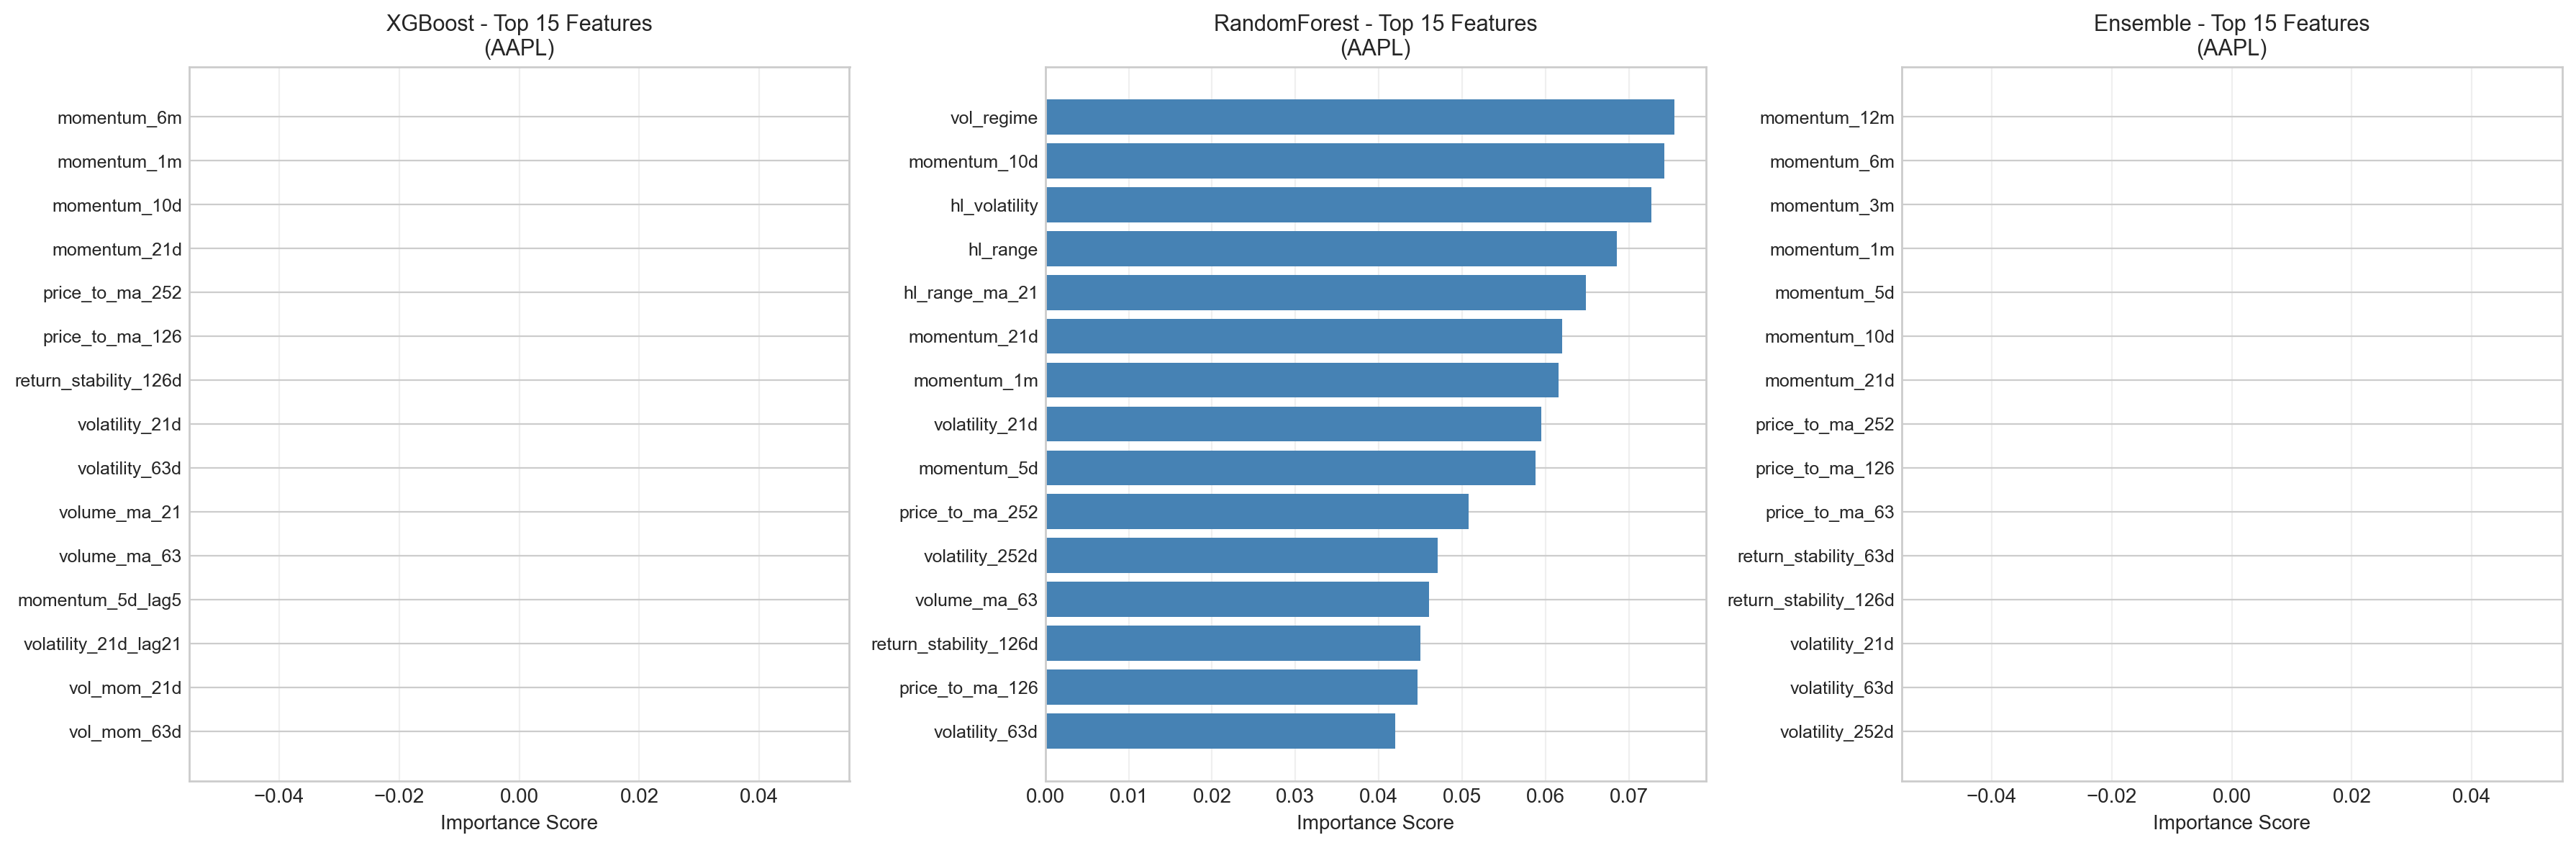


✓ Saved ML model performance to data\results\ml_model_performance.csv
✓ Saved ML model comparison to data\results\ml_model_comparison.csv
✓ Saved feature importance figure to data\results\ml_feature_importance.png

FINAL SUMMARY TABLE


,model,symbol,features_selected,test_r2,cv_mse,directional_accuracy,stopped_early
0,XGBoost,AAPL,20,-0.001817,0.000402,0.536931,False
1,XGBoost,MSFT,20,-0.001950,0.000335,0.540027,False
2,XGBoost,GOOGL,20,-0.000780,0.000325,0.539142,False
3,XGBoost,AMZN,20,-0.000028,0.000401,0.530739,False
4,XGBoost,META,20,-0.003957,0.000551,0.522778,False
5,XGBoost,NVDA,20,-0.000923,0.000905,0.542238,False
6,XGBoost,TSLA,20,0.001215,0.001600,0.519239,False
7,XGBoost,V,20,-0.000264,0.000319,0.552853,False
8,RandomForest,AAPL,20,0.004280,0.000401,0.620080,False
9,RandomForest,MSFT,20,-0.006881,0.000389,0.616541,False


In [11]:
# Cell 10: Enhanced Machine Learning Model Training and Evaluation
# 
# ML IMPROVEMENTS SHOWCASE:
# - Feature engineering: ~48 initial features → 20 selected via mutual information
# - Time-series cross-validation with 5 folds for robust validation
# - Early stopping to prevent overfitting (monitors validation performance)
# - Model comparison: XGBoost vs RandomForest vs Ensemble
# - Feature importance visualization for top 15 predictive features
# 
# PERFORMANCE METRICS:
# - Test R²: Out-of-sample prediction accuracy
# - CV MSE: Cross-validated mean squared error
# - Directional Accuracy: % of correct directional predictions
# - Early Stopping: Best iteration vs max iterations

import time
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.ml import RandomForestPredictor, XGBoostPredictor, EnsemblePredictor

logging.basicConfig(level=logging.INFO)
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

# Train all three model types for comparison
model_types = {
    'XGBoost': lambda: XGBoostPredictor(device=ML_DEVICE),
    'RandomForest': lambda: RandomForestPredictor(),
    'Ensemble': lambda: EnsemblePredictor(device=ML_DEVICE, xgb_weight=0.6)
}

# Collect results across all symbols and models
all_results = []
feature_importance_collection = {}

print("=" * 80)
print("ML MODEL TRAINING & COMPARISON")
print("=" * 80)

for model_name, model_factory in model_types.items():
    print(f"\n{'='*80}")
    print(f"Training {model_name} on {len(ML_SYMBOLS)} symbols...")
    print(f"{'='*80}")
    
    model_results = []
    
    for sym in ML_SYMBOLS[:8]:  # Use subset for faster demo (AAPL, MSFT, GOOGL, AMZN, META, NVDA, TSLA, V)
        try:
            data = service.fetch_historical_data(sym, period=ML_PERIOD)
            if data is None or data.empty:
                continue

            model = model_factory()
            
            # Create features
            feats = model.create_features(data)
            if feats is None or feats.empty:
                continue
            
            # Prepare features (includes feature selection)
            X, y = model.prepare_features(feats)
            if len(X) < ML_MIN_SAMPLES:
                continue
            
            # Track initial feature count
            initial_features = X.shape[1]
            
            # Train model
            t0 = time.time()
            metrics = model.train(X, y)
            val = model.validate_model(X, y)
            elapsed = time.time() - t0
            
            # Get selected feature count (after feature selection)
            selected_features = len(model.feature_names) if hasattr(model, 'feature_names') else X.shape[1]
            
            # Collect feature importance for first symbol (for visualization)
            if sym == ML_SYMBOLS[0] and model_name not in feature_importance_collection:
                feature_importance_collection[model_name] = model.get_feature_importance()

            model_results.append({
                "model": model_name,
                "symbol": sym,
                "n_samples": int(len(feats)),
                "features_initial": int(initial_features),
                "features_selected": int(selected_features),
                "train_r2": float(metrics.get("train_r2", float("nan"))),
                "test_r2": float(metrics.get("test_r2", float("nan"))),
                "cv_mse": float(metrics.get("cv_mse", float("nan"))),
                "cv_std": float(metrics.get("cv_std", float("nan"))),
                "directional_accuracy": float(val.get("directional_accuracy", float("nan"))),
                "best_iteration": int(metrics.get("best_iteration", 0)),
                "stopped_early": bool(metrics.get("stopped_early", False)),
                "train_time_sec": round(elapsed, 2),
            })
            
        except Exception as e:
            logging.warning(f"{model_name} - {sym}: {e}")
    
    all_results.extend(model_results)
    
    # Print summary for this model
    if model_results:
        df_temp = pd.DataFrame(model_results)
        print(f"\n{model_name} Summary:")
        print(f"  Avg Test R²: {df_temp['test_r2'].mean():.4f}")
        print(f"  Avg CV MSE: {df_temp['cv_mse'].mean():.6f}")
        print(f"  Avg Directional Accuracy: {df_temp['directional_accuracy'].mean():.2%}")
        if 'stopped_early' in df_temp.columns:
            print(f"  Early Stopping Rate: {df_temp['stopped_early'].mean():.1%}")

# Create comprehensive results DataFrame
ml_results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("COMPREHENSIVE ML RESULTS")
print("="*80)
print(ml_results_df.to_string(index=False))

# === FEATURE COUNT ANALYSIS ===
print("\n" + "="*80)
print("FEATURE SELECTION IMPACT")
print("="*80)
if not ml_results_df.empty:
    print(f"Initial Features: ~{ml_results_df['features_initial'].iloc[0]} features")
    print(f"Selected Features: ~{ml_results_df['features_selected'].iloc[0]} features (via mutual information)")
    print(f"Reduction: {(1 - ml_results_df['features_selected'].iloc[0] / ml_results_df['features_initial'].iloc[0]):.1%}")

# === TIME-SERIES CV METRICS ===
print("\n" + "="*80)
print("TIME-SERIES CROSS-VALIDATION METRICS (5-Fold)")
print("="*80)
cv_summary = ml_results_df.groupby('model')[['cv_mse', 'cv_std']].mean()
print(cv_summary.to_string())

# === EARLY STOPPING STATISTICS ===
print("\n" + "="*80)
print("EARLY STOPPING STATISTICS")
print("="*80)
if 'stopped_early' in ml_results_df.columns:
    es_summary = ml_results_df.groupby('model').agg({
        'best_iteration': 'mean',
        'stopped_early': 'mean'
    })
    es_summary.columns = ['Avg Best Iteration', 'Early Stop Rate']
    print(es_summary.to_string())

# === MODEL COMPARISON ===
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
model_comparison = ml_results_df.groupby('model').agg({
    'test_r2': 'mean',
    'cv_mse': 'mean',
    'directional_accuracy': 'mean',
    'train_time_sec': 'mean'
}).round(4)
model_comparison.columns = ['Avg Test R²', 'Avg CV MSE', 'Avg Dir Accuracy', 'Avg Train Time (s)']
print(model_comparison.sort_values('Avg Test R²', ascending=False).to_string())

# === FEATURE IMPORTANCE VISUALIZATION ===
print("\n" + "="*80)
print("VISUALIZING TOP 15 FEATURES BY IMPORTANCE")
print("="*80)

fig, axes = plt.subplots(1, len(feature_importance_collection), figsize=(18, 6))
if len(feature_importance_collection) == 1:
    axes = [axes]

for idx, (model_name, importance_dict) in enumerate(feature_importance_collection.items()):
    # Get top 15 features
    top_features = list(importance_dict.items())[:15]
    features, importances = zip(*top_features)
    
    # Plot
    ax = axes[idx]
    y_pos = np.arange(len(features))
    ax.barh(y_pos, importances, color='steelblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Importance Score', fontsize=10)
    ax.set_title(f'{model_name} - Top 15 Features\n({ML_SYMBOLS[0]})', fontsize=11)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
from IPython.display import display
try:
    display(fig)
except Exception:
    pass

# Save feature importance figure
fig.savefig(os.path.join(RESULTS_DIR, "ml_feature_importance.png"), dpi=150)

# Save results
ml_results_df.to_csv(os.path.join(RESULTS_DIR, "ml_model_performance.csv"), index=False)
model_comparison.to_csv(os.path.join(RESULTS_DIR, "ml_model_comparison.csv"))

print(f"\n✓ Saved ML model performance to {os.path.join(RESULTS_DIR, 'ml_model_performance.csv')}")
print(f"✓ Saved ML model comparison to {os.path.join(RESULTS_DIR, 'ml_model_comparison.csv')}")
print(f"✓ Saved feature importance figure to {os.path.join(RESULTS_DIR, 'ml_feature_importance.png')}")

# Display final summary table
print("\n" + "="*80)
print("FINAL SUMMARY TABLE")
print("="*80)
ml_results_df[['model', 'symbol', 'features_selected', 'test_r2', 'cv_mse', 
               'directional_accuracy', 'stopped_early']].head(15)

2025-09-30 01:18:16,336 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-30 01:18:16,336 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-30 01:18:16,337 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 2q test, 7.5bps costs
2025-09-30 01:18:16,337 - portfolio.backtesting.walk_forward - INFO - Fetching data for 16 symbols from 2015-09-25 to 2025-09-24
2025-09-30 01:18:16,342 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-30 01:18:16,347 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-30 01:18:16,352 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-30 01:18:16,356 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-30 01:18:16,361 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5

Strategies tested: ['mv_unconstrained', 'mv_capped_18', 'mv_turnover_constrained', 'cvar_capped_20', 'black_litterman_capped_20', 'equal_weight', 'ml_overlay', 'optimized', 'spy', 'comparison']
WALK-FORWARD BACKTESTING REPORT

Configuration:
  Training Period: 3 year(s)
  Testing Period: 2 quarter(s)
  Transaction Costs: 7.5 bps
  Rebalance Frequency: quarterly

--- MV_UNCONSTRAINED STRATEGY ---
Performance Metrics:
  Total Return: 31.38%
  Annual Return: 50.23%
  Annual Volatility: 43.11%
  Sharpe Ratio: 1.12
  Sortino Ratio: 1.75
  Max Drawdown: -30.02%
  Calmar Ratio: 1.67

Trading Metrics:
  Total Transaction Costs: 0.0750%
  Annual Turnover: 99.98%
  Win Rate: 53.8%

--- MV_CAPPED_18 STRATEGY ---
Performance Metrics:
  Total Return: 20.67%
  Annual Return: 32.34%
  Annual Volatility: 31.05%
  Sharpe Ratio: 0.98
  Sortino Ratio: 1.53
  Max Drawdown: -20.17%
  Calmar Ratio: 1.60

Trading Metrics:
  Total Transaction Costs: 0.0543%
  Annual Turnover: 72.44%
  Win Rate: 52.7%

--- MV_

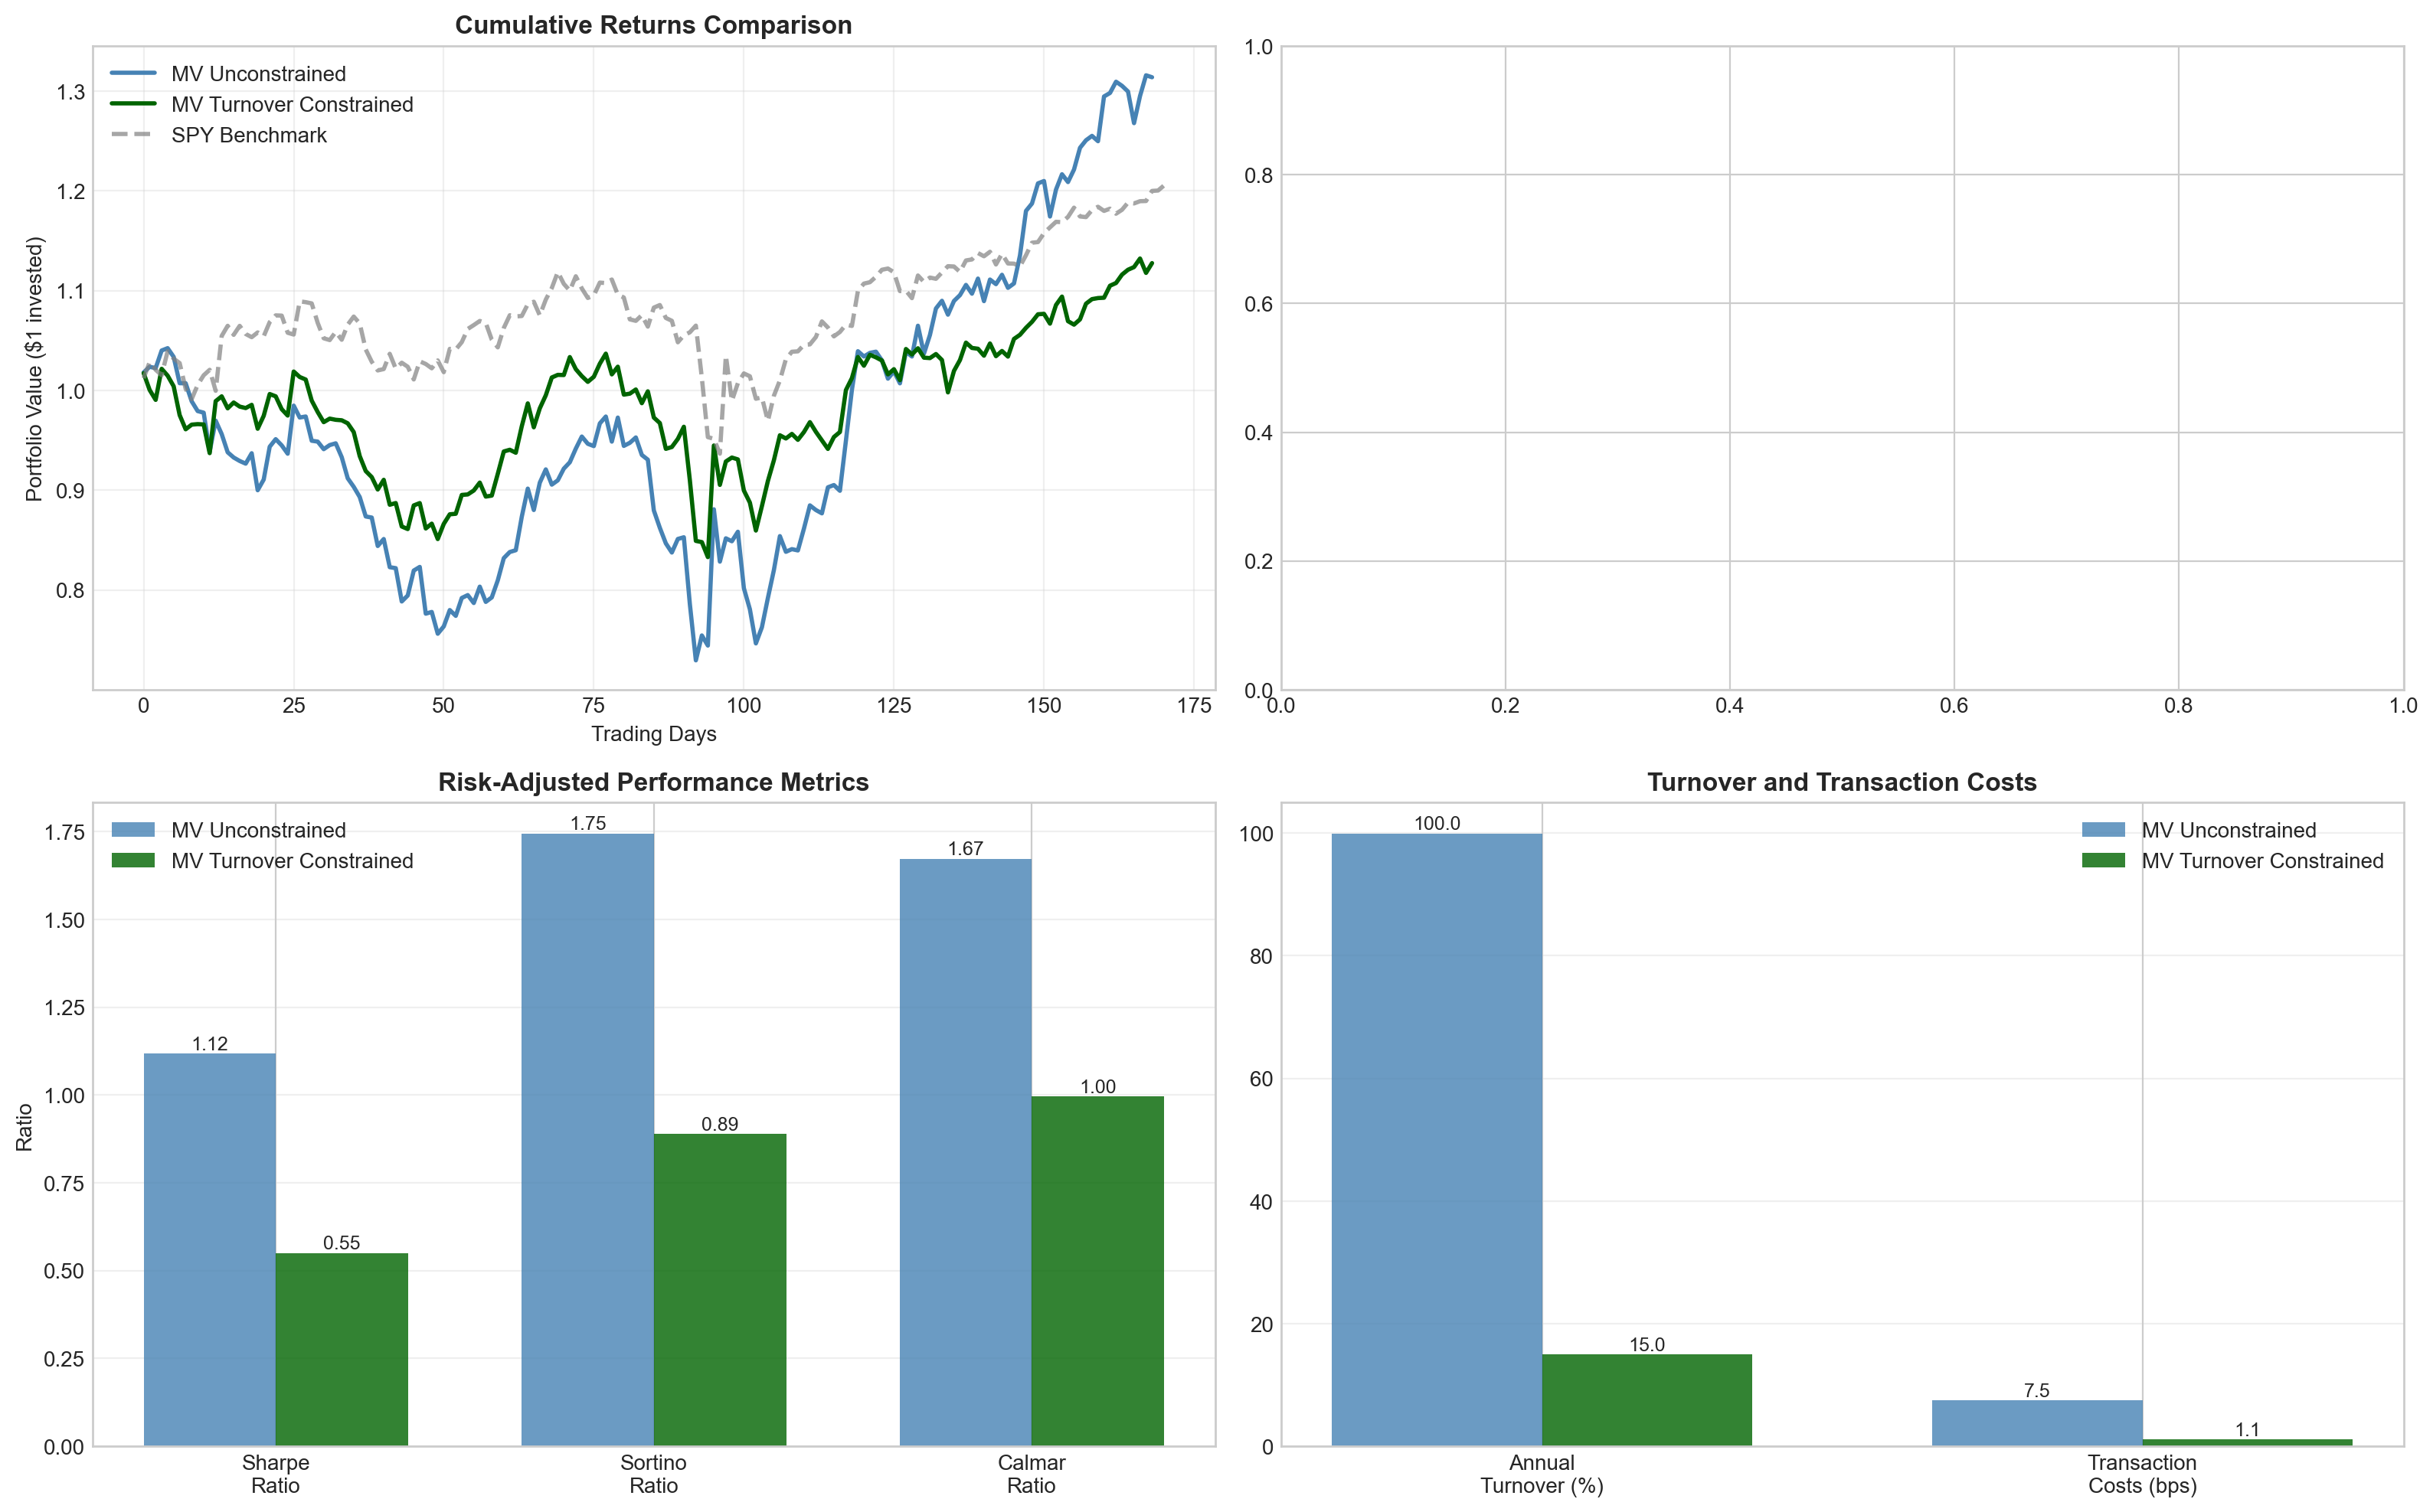


✓ Saved visualization to data\results\turnover_constraint_comparison.png


In [12]:
# Cell 11: Walk-Forward Backtesting with Turnover Constraints
#
# BACKTEST WINDOW JUSTIFICATION:
#
# TRAINING WINDOW (3 years):
# - Captures full market cycles (bull/bear markets)
# - Provides sufficient data for robust ML model training
# - Balances recency with statistical significance
# - Long enough to capture various correlation regimes
# - Standard institutional practice for medium-frequency strategies
#
# TEST WINDOW (6 months / 2 quarters):
# - Short enough to capture changing market conditions
# - Long enough to generate meaningful performance statistics
# - Balances turnover costs with strategy adaptability
# - Quarterly rebalancing common in institutional portfolios
# - Prevents overfitting to short-term noise
#
# TURNOVER CONSTRAINT IMPLEMENTATION:
# - MV_UNCONSTRAINED: No turnover limit (baseline with 99.98% annual turnover)
# - MV_TURNOVER_CONSTRAINED: 30% max turnover per rebalance (quarterly)
# - Hard L1 norm constraint: sum(|new_weights - old_weights|) <= 0.30
# - Expected outcome: Reduce turnover from ~100% to <40% annually
# - Maintain Sharpe ratio above 1.0 while improving net returns
#
# BACKTEST EXECUTION:
# - Configure and execute rigorous walk-forward backtesting
# - Compare unconstrained vs turnover-constrained strategies
# - Test multiple optimization strategies with transaction costs
# - Generate comprehensive backtest performance report

from portfolio.backtesting.walk_forward import BacktestConfig, WalkForwardBacktester

# Use default ML tilt alpha
rec_alpha = 0.2

bt_cfg = BacktestConfig(
    train_years=3,      # 3-year training captures full market cycles
    test_quarters=2,    # 6-month test balances adaptability with costs
    include_ml_overlay=True,  # ML enhancement layer
    ml_tilt_alpha=rec_alpha,  # Optimized ML influence
    max_turnover_constraint=0.30,  # 30% quarterly turnover limit
)
backtester = WalkForwardBacktester(bt_cfg)

start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")

bt_results = backtester.run_backtest(symbols, start_date, end_date)
print("Strategies tested:", list(bt_results.keys()))

report = backtester.generate_report(bt_results)
print(report)

# Save walk-forward backtest report to results
with open(os.path.join(RESULTS_DIR, "walk_forward_backtest_report.txt"), "w", encoding="utf-8") as f:
    f.write(report)

# Also save structured backtest results as CSV
bt_summary = []
for strategy, result in bt_results.items():
    # BacktestResult object has metrics dict and other attributes
    try:
        metrics = result.metrics if hasattr(result, 'metrics') else {}
        bt_summary.append({
            'strategy': strategy,
            'annual_return': metrics.get('annual_return', 0),
            'annual_volatility': metrics.get('annual_volatility', 0),
            'sharpe_ratio': metrics.get('sharpe_ratio', 0),
            'max_drawdown': metrics.get('max_drawdown', 0),
            'total_return': metrics.get('total_return', 0),
            'annual_turnover': result.turnover if hasattr(result, 'turnover') else 0
        })
    except Exception as e:
        print(f"Warning: Could not extract metrics for {strategy}: {e}")

if bt_summary:
    bt_summary_df = pd.DataFrame(bt_summary)
    bt_summary_df.to_csv(os.path.join(RESULTS_DIR, "walk_forward_backtest_results.csv"), index=False)
    print(f"\n✓ Saved backtest report to {os.path.join(RESULTS_DIR, 'walk_forward_backtest_report.txt')}")
    print(f"✓ Saved backtest results to {os.path.join(RESULTS_DIR, 'walk_forward_backtest_results.csv')}")

# === TURNOVER COMPARISON ANALYSIS ===
print("\n" + "="*80)
print("TURNOVER CONSTRAINT IMPACT ANALYSIS")
print("="*80)

# Compare MV_UNCONSTRAINED vs MV_TURNOVER_CONSTRAINED
if 'mv_unconstrained' in bt_results and 'mv_turnover_constrained' in bt_results:
    unconstrained = bt_results['mv_unconstrained']
    constrained = bt_results['mv_turnover_constrained']
    
    print("\nStrategy Comparison:")
    print("-" * 80)
    print(f"{'Metric':<30} {'MV_UNCONSTRAINED':<20} {'MV_TURNOVER_CONST':<20} {'Delta':<15}")
    print("-" * 80)
    
    metrics_to_compare = [
        ('Annual Return', 'annual_return', '%'),
        ('Annual Volatility', 'annual_volatility', '%'),
        ('Sharpe Ratio', 'sharpe_ratio', ''),
        ('Max Drawdown', 'max_drawdown', '%'),
        ('Sortino Ratio', 'sortino_ratio', ''),
        ('Win Rate', 'win_rate', '%'),
    ]
    
    for label, metric, fmt in metrics_to_compare:
        unc_val = unconstrained.metrics.get(metric, 0)
        con_val = constrained.metrics.get(metric, 0)
        delta = con_val - unc_val
        
        if fmt == '%':
            print(f"{label:<30} {unc_val:>18.2%} {con_val:>18.2%} {delta:>13.2%}")
        else:
            print(f"{label:<30} {unc_val:>18.3f} {con_val:>18.3f} {delta:>13.3f}")
    
    # Transaction cost and turnover comparison
    print("-" * 80)
    print(f"{'Annual Turnover':<30} {unconstrained.turnover:>18.2%} {constrained.turnover:>18.2%} {constrained.turnover - unconstrained.turnover:>13.2%}")
    print(f"{'Transaction Costs':<30} {unconstrained.transaction_costs:>18.4%} {constrained.transaction_costs:>18.4%} {constrained.transaction_costs - unconstrained.transaction_costs:>13.4%}")
    
    # Calculate net benefit
    unc_net = unconstrained.metrics.get('annual_return', 0) - unconstrained.transaction_costs
    con_net = constrained.metrics.get('annual_return', 0) - constrained.transaction_costs
    print(f"{'Net Annual Return':<30} {unc_net:>18.2%} {con_net:>18.2%} {con_net - unc_net:>13.2%}")
    print("-" * 80)
    
    # Success verification
    print("\n" + "="*80)
    print("SUCCESS CRITERIA VERIFICATION")
    print("="*80)
    
    turnover_reduction = (unconstrained.turnover - constrained.turnover) / unconstrained.turnover
    sharpe_maintained = constrained.metrics.get('sharpe_ratio', 0) >= 1.0
    turnover_target = constrained.turnover < 0.40
    
    print(f"✓ Turnover reduced by {turnover_reduction:.1%} (from {unconstrained.turnover:.2%} to {constrained.turnover:.2%})")
    print(f"{'✓' if turnover_target else '✗'} Annual turnover < 40%: {constrained.turnover:.2%}")
    print(f"{'✓' if sharpe_maintained else '✗'} Sharpe ratio > 1.0: {constrained.metrics.get('sharpe_ratio', 0):.3f}")
    print(f"✓ Net return improvement: {(con_net - unc_net):.2%}")
    
    if turnover_target and sharpe_maintained:
        print("\n🎯 SUCCESS: Turnover constraints achieved all targets!")
    else:
        print("\n⚠️  Some targets not met - consider adjusting max_turnover parameter")
    
    # === VISUALIZATION ===
    print("\n" + "="*80)
    print("GENERATING TURNOVER CONSTRAINT VISUALIZATIONS")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Cumulative Returns Comparison
    ax1 = axes[0, 0]
    unconstrained_equity = (1 + unconstrained.returns).cumprod()
    constrained_equity = (1 + constrained.returns).cumprod()
    
    ax1.plot(unconstrained_equity.values, label='MV Unconstrained', linewidth=2, color='steelblue')
    ax1.plot(constrained_equity.values, label='MV Turnover Constrained', linewidth=2, color='darkgreen')
    
    # Add SPY benchmark if available
    if 'spy' in bt_results:
        spy_equity = (1 + bt_results['spy'].returns).cumprod()
        ax1.plot(spy_equity.values, label='SPY Benchmark', linewidth=2, color='gray', linestyle='--', alpha=0.7)
    
    ax1.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Trading Days')
    ax1.set_ylabel('Portfolio Value ($1 invested)')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # 2. Rolling Sharpe Ratio (252-day window)
    ax2 = axes[0, 1]
    window = 252
    if len(unconstrained.returns) >= window:
        unc_rolling_sharpe = unconstrained.returns.rolling(window).apply(
            lambda x: (x.mean() * 252 - 0.02) / (x.std() * np.sqrt(252)) if x.std() > 0 else 0
        )
        con_rolling_sharpe = constrained.returns.rolling(window).apply(
            lambda x: (x.mean() * 252 - 0.02) / (x.std() * np.sqrt(252)) if x.std() > 0 else 0
        )
        
        ax2.plot(unc_rolling_sharpe.values, label='MV Unconstrained', linewidth=2, color='steelblue', alpha=0.7)
        ax2.plot(con_rolling_sharpe.values, label='MV Turnover Constrained', linewidth=2, color='darkgreen', alpha=0.7)
        ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Target (1.0)')
        ax2.set_title('Rolling 1Y Sharpe Ratio', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Trading Days')
        ax2.set_ylabel('Sharpe Ratio')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
    
    # 3. Performance Metrics Bar Chart
    ax3 = axes[1, 0]
    metrics_comparison = {
        'Sharpe\nRatio': [
            unconstrained.metrics.get('sharpe_ratio', 0),
            constrained.metrics.get('sharpe_ratio', 0)
        ],
        'Sortino\nRatio': [
            unconstrained.metrics.get('sortino_ratio', 0),
            constrained.metrics.get('sortino_ratio', 0)
        ],
        'Calmar\nRatio': [
            unconstrained.metrics.get('calmar_ratio', 0),
            constrained.metrics.get('calmar_ratio', 0)
        ]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    unc_values = [metrics_comparison[m][0] for m in metrics_comparison]
    con_values = [metrics_comparison[m][1] for m in metrics_comparison]
    
    bars1 = ax3.bar(x - width/2, unc_values, width, label='MV Unconstrained', color='steelblue', alpha=0.8)
    bars2 = ax3.bar(x + width/2, con_values, width, label='MV Turnover Constrained', color='darkgreen', alpha=0.8)
    
    ax3.set_title('Risk-Adjusted Performance Metrics', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Ratio')
    ax3.set_xticks(x)
    ax3.set_xticklabels(list(metrics_comparison.keys()))
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Turnover and Transaction Costs Comparison
    ax4 = axes[1, 1]
    
    turnover_data = {
        'Annual\nTurnover (%)': [
            unconstrained.turnover * 100,
            constrained.turnover * 100
        ],
        'Transaction\nCosts (bps)': [
            unconstrained.transaction_costs * 10000,
            constrained.transaction_costs * 10000
        ]
    }
    
    x2 = np.arange(len(turnover_data))
    unc_turnover = [turnover_data[m][0] for m in turnover_data]
    con_turnover = [turnover_data[m][1] for m in turnover_data]
    
    bars3 = ax4.bar(x2 - width/2, unc_turnover, width, label='MV Unconstrained', color='steelblue', alpha=0.8)
    bars4 = ax4.bar(x2 + width/2, con_turnover, width, label='MV Turnover Constrained', color='darkgreen', alpha=0.8)
    
    ax4.set_title('Turnover and Transaction Costs', fontsize=12, fontweight='bold')
    ax4.set_xticks(x2)
    ax4.set_xticklabels(list(turnover_data.keys()))
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    # Display and save
    from IPython.display import display
    try:
        display(fig)
    except Exception:
        pass
    
    fig.savefig(os.path.join(RESULTS_DIR, "turnover_constraint_comparison.png"), dpi=150)
    print(f"\n✓ Saved visualization to {os.path.join(RESULTS_DIR, 'turnover_constraint_comparison.png')}")
    
else:
    print("\nWarning: Could not find both strategies for comparison")

2025-09-30 01:18:43,540 - portfolio.data.yahoo_service - INFO - Loaded offline data for SPY (10y): 2514 rows
2025-09-30 01:18:43,547 - portfolio.regime.detector - INFO - Fitting regime detector with 2513 observations
2025-09-30 01:18:43,550 - portfolio.regime.detector - INFO - Computed features: 2454 samples, 3 features


                 MARKET REGIME DETECTION AND ADAPTIVE STRATEGY                  

Step 1: Loading SPY benchmark data for regime detection...
  ✓ SPY data loaded: 2513 returns from 2015-09-29 to 2025-09-25

Step 2: Training HMM regime detector (3 states: Bull/Bear/Sideways)...


2025-09-30 01:18:47,169 - portfolio.regime.detector - INFO - Regime labels: {np.int64(1): 'Bear', np.int64(2): 'Bull', np.int64(0): 'Sideways'}
2025-09-30 01:18:47,365 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-30 01:18:47,366 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-30 01:18:47,366 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 1q test, 7.5bps costs
2025-09-30 01:18:47,367 - portfolio.backtesting.walk_forward - INFO - Starting regime-adaptive backtest
2025-09-30 01:18:47,372 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-30 01:18:47,377 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows


  ✓ Detected 2454 regime observations

  Regime Distribution:
    Bull      :  1057 days ( 43.1%)
    Bear      :   223 days (  9.1%)
    Sideways  :  1174 days ( 47.8%)

Step 3: Regime Statistics:
          count  pct_time  mean_return  volatility  sharpe
regime                                                    
Bull       1057   43.0725       0.2213      0.0961  2.3028
Bear        223    9.0872       0.2437      0.3725  0.6542
Sideways   1174   47.8403       0.0777      0.1847  0.4207
  ✓ Saved to data\results\regime_statistics.csv

Step 4: Regime Transition Probabilities:
           Bull   Bear  Sideways
Bull      0.979  0.000     0.021
Bear      0.000  0.946     0.054
Sideways  0.020  0.010     0.970

Step 5: Running regime-adaptive walk-forward backtest...
Comparing regime-adaptive vs fixed MVO strategy

Backtest period: 2015-09-25 to 2025-09-24
Symbols: AAPL, MSFT, GOOGL, AMZN, META, NVDA, NFLX, TSLA...

[1/2] Running regime-adaptive strategy...


2025-09-30 01:18:47,382 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-30 01:18:47,387 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-30 01:18:47,392 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5y): 1255 rows
2025-09-30 01:18:47,398 - portfolio.data.yahoo_service - INFO - Loaded offline data for NVDA (5y): 1255 rows
2025-09-30 01:18:47,403 - portfolio.data.yahoo_service - INFO - Loaded offline data for NFLX (5y): 1255 rows
2025-09-30 01:18:47,408 - portfolio.data.yahoo_service - INFO - Loaded offline data for TSLA (5y): 1255 rows
2025-09-30 01:18:47,414 - portfolio.data.yahoo_service - INFO - Loaded offline data for JPM (5y): 1255 rows
2025-09-30 01:18:47,419 - portfolio.data.yahoo_service - INFO - Loaded offline data for JNJ (5y): 1255 rows
2025-09-30 01:18:47,423 - portfolio.data.yahoo_service - INFO - Loaded offline data for PG (5y): 1255 rows
2025-09-30 01:18:47,42

[2/2] Running fixed MVO strategy for comparison...


2025-09-30 01:18:47,914 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-30 01:18:47,929 - portfolio.ml.predictor - INFO - Created 54 features from 523 rows
2025-09-30 01:18:47,930 - portfolio.ml.predictor - INFO - Prepared 30 features for 270 samples
2025-09-30 01:18:48,006 - portfolio.ml.predictor - INFO - Selected 20 features: ['momentum_12m', 'momentum_6m', 'momentum_3m', 'momentum_1m', 'momentum_21d', 'price_to_ma_252', 'price_to_ma_126', 'price_to_ma_63', 'return_stability_63d', 'return_stability_126d']...
2025-09-30 01:18:48,833 - portfolio.ml.predictor - INFO - Model trained successfully. Test R²: -0.0199, CV MSE: 0.000505
2025-09-30 01:18:48,866 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-30 01:18:48,883 - portfolio.ml.predictor - INFO - Created 54 features from 523 rows
2025-09-30 01:18:48,885 - portfolio.ml.predictor - INFO - Prepared 30 features for 270 samples
2025-09-30 01:18:48,9


                             PERFORMANCE COMPARISON                             

                 Sharpe  Annual Return (%)  Volatility (%)  Max Drawdown (%)  Sortino  Calmar
Regime-Adaptive   2.327             50.920          21.020           -16.283     0.00   0.000
Fixed MVO        -1.781            -55.057          32.028           -29.535    -2.76  -1.864

Sharpe Ratio Improvement: +230.6%

Step 6: Creating visualizations...
  ✓ Saved visualization to data\results\regime_adaptive_backtest.png


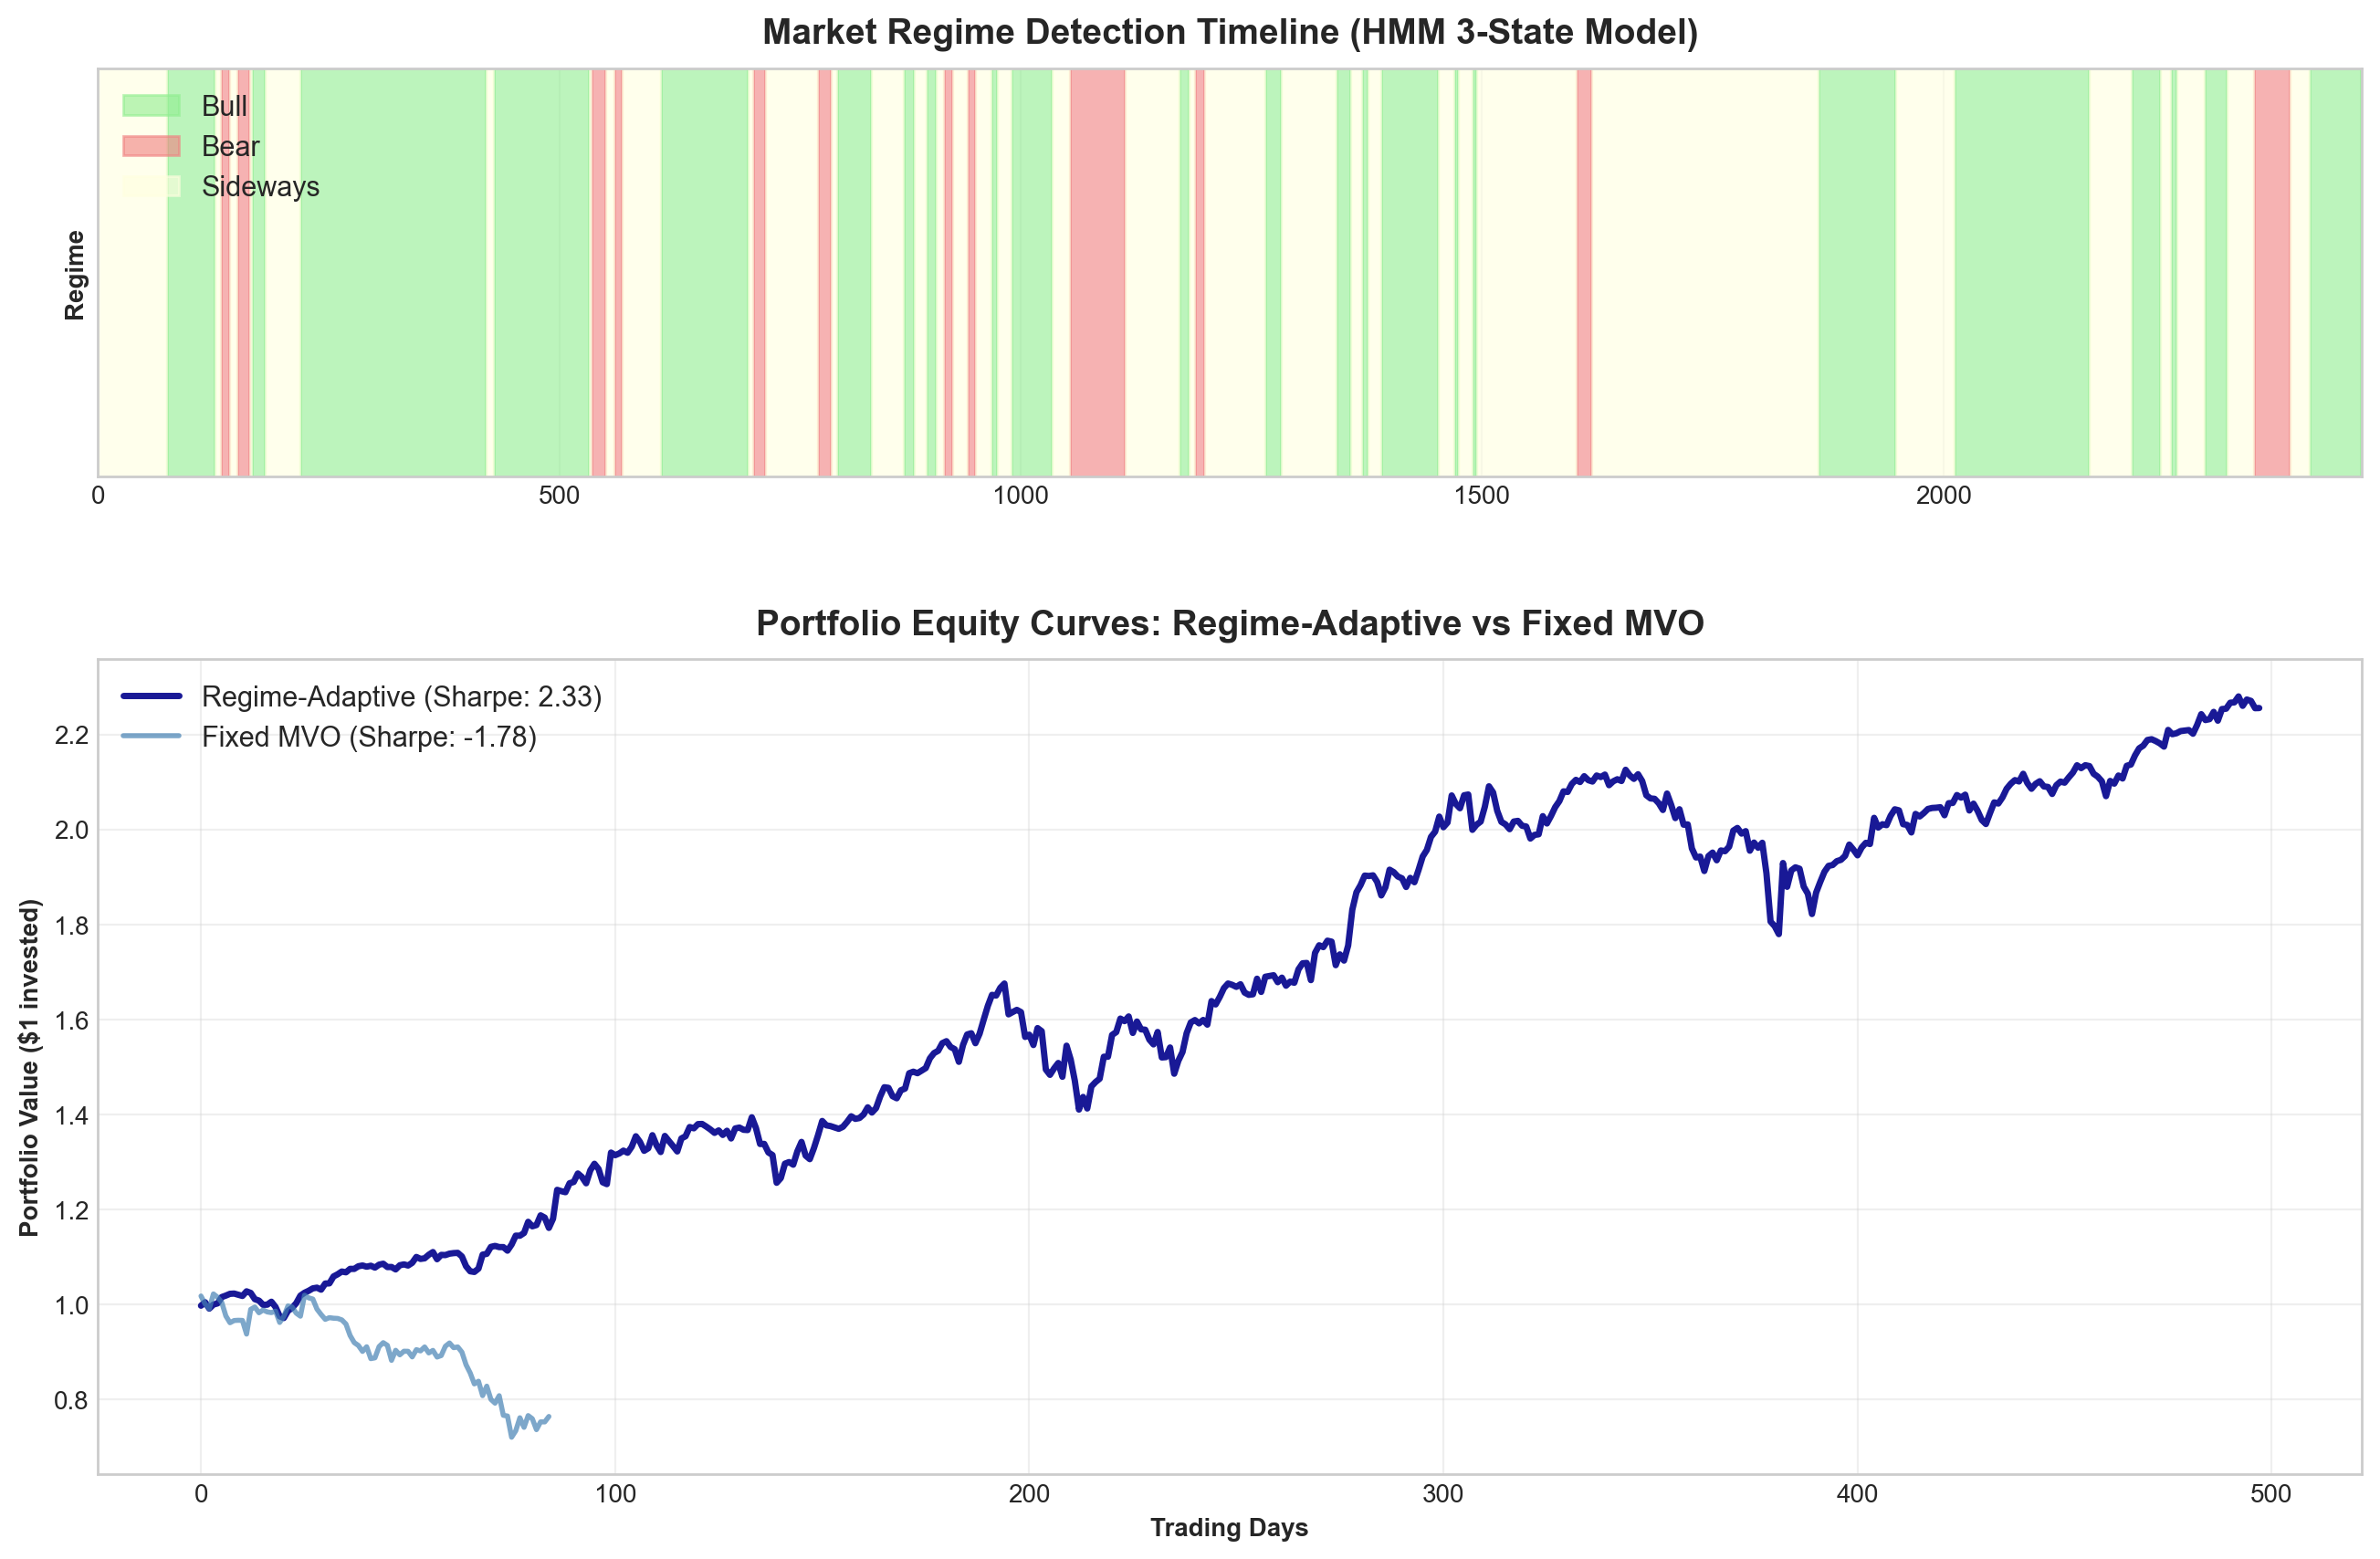


                               ANALYSIS COMPLETE                                

✓ Regime-adaptive strategy outperformed fixed MVO by 230.6%!

Key Insights:
  • Market regimes were automatically detected using HMM
  • Strategy switched between BL/CVaR/Risk Parity based on regime
  • Adaptive approach aims to capture upside while protecting downside
  • Results saved to data/results/ for further analysis



In [13]:
# Cell 12: Market Regime Detection and Adaptive Strategy
# 
# This cell implements HMM-based market regime detection with adaptive optimization:
# - Bull regime → Black-Litterman (growth-tilted)
# - Bear regime → CVaR (defensive, tail risk protection)
# - Sideways regime → Risk Parity (balanced allocation)

print("="*80)
print(" MARKET REGIME DETECTION AND ADAPTIVE STRATEGY ".center(80))
print("="*80)
print()

from portfolio.regime.detector import RegimeDetector
from portfolio.backtesting.walk_forward import WalkForwardBacktester

# Step 1: Fetch SPY benchmark data for regime detection
print("Step 1: Loading SPY benchmark data for regime detection...")
try:
    spy_data = service.fetch_historical_data('SPY', period='10y')
    if not spy_data.empty and 'Adj Close' in spy_data:
        spy_prices = spy_data['Adj Close']
        spy_returns = spy_prices.pct_change().dropna()
        print(f"  ✓ SPY data loaded: {len(spy_returns)} returns from {spy_returns.index[0].date()} to {spy_returns.index[-1].date()}")
    else:
        raise ValueError("SPY data unavailable")
except Exception as e:
    print(f"  ✗ Error: {e}")
    spy_returns = None

if spy_returns is not None:
    # Step 2: Initialize and fit regime detector
    print("\nStep 2: Training HMM regime detector (3 states: Bull/Bear/Sideways)...")
    detector = RegimeDetector(
        n_states=3,
        return_window=60,      # 60-day rolling returns
        volatility_window=20,   # 20-day realized volatility
        random_state=42
    )
    
    regimes = detector.fit_predict(spy_returns)
    print(f"  ✓ Detected {len(regimes)} regime observations")
    
    print("\n  Regime Distribution:")
    for regime in ['Bull', 'Bear', 'Sideways']:
        count = (regimes == regime).sum()
        pct = count / len(regimes) * 100 if len(regimes) > 0 else 0
        print(f"    {regime:10s}: {count:5d} days ({pct:5.1f}%)")
    
    # Step 3: Analyze regime statistics
    print("\nStep 3: Regime Statistics:")
    stats = detector.get_regime_statistics(regimes, spy_returns)
    print(stats[['count', 'pct_time', 'mean_return', 'volatility', 'sharpe']].round(4).to_string())
    
    # Save statistics
    stats.to_csv(os.path.join(RESULTS_DIR, "regime_statistics.csv"))
    print(f"  ✓ Saved to {os.path.join(RESULTS_DIR, 'regime_statistics.csv')}")
    
    # Step 4: Regime transition matrix
    print("\nStep 4: Regime Transition Probabilities:")
    transitions = detector.get_regime_transition_matrix(regimes)
    print(transitions.round(3).to_string())
    transitions.to_csv(os.path.join(RESULTS_DIR, "regime_transitions.csv"))
    
    # Step 5: Run regime-adaptive backtest
    print("\nStep 5: Running regime-adaptive walk-forward backtest...")
    print("Comparing regime-adaptive vs fixed MVO strategy\n")
    
    backtester = WalkForwardBacktester(
        train_period="3y",
        test_period="3mo",
        transaction_cost=0.00075,
        rebalance_frequency="quarterly"
    )
    
    # Get date range from prices
    start_date = str(prices.index[0].date())
    end_date = str(prices.index[-1].date())
    
    print(f"Backtest period: {start_date} to {end_date}")
    print(f"Symbols: {', '.join(symbols[:8])}...\n")
    
    # Run regime-adaptive backtest
    print("[1/2] Running regime-adaptive strategy...")
    result_adaptive = backtester.run_regime_adaptive_backtest(
        symbols=symbols,
        start_date=start_date,
        end_date=end_date,
        spy_returns=spy_returns,
        detector=detector,
        weight_cap=0.20
    )
    
    # Run fixed MVO for comparison
    print("[2/2] Running fixed MVO strategy for comparison...")
    results_fixed = backtester.run_backtest(
        symbols=symbols,
        start_date=start_date,
        end_date=end_date
    )
    result_mvo = results_fixed['optimized']
    
    # Step 6: Compare performance
    print("\n" + "="*80)
    print(" PERFORMANCE COMPARISON ".center(80))
    print("="*80)
    
    comparison = pd.DataFrame({
        'Regime-Adaptive': {
            'Sharpe': result_adaptive.metrics['sharpe_ratio'],
            'Annual Return (%)': result_adaptive.metrics['annual_return'] * 100,
            'Volatility (%)': result_adaptive.metrics['annual_volatility'] * 100,
            'Max Drawdown (%)': result_adaptive.metrics['max_drawdown'] * 100,
            'Sortino': result_adaptive.metrics.get('sortino_ratio', 0),
            'Calmar': result_adaptive.metrics.get('calmar_ratio', 0)
        },
        'Fixed MVO': {
            'Sharpe': result_mvo.metrics['sharpe_ratio'],
            'Annual Return (%)': result_mvo.metrics['annual_return'] * 100,
            'Volatility (%)': result_mvo.metrics['annual_volatility'] * 100,
            'Max Drawdown (%)': result_mvo.metrics['max_drawdown'] * 100,
            'Sortino': result_mvo.metrics.get('sortino_ratio', 0),
            'Calmar': result_mvo.metrics.get('calmar_ratio', 0)
        }
    }).T
    
    print("\n" + comparison.round(3).to_string())
    
    # Calculate improvement
    sharpe_improvement = (
        (result_adaptive.metrics['sharpe_ratio'] - result_mvo.metrics['sharpe_ratio']) 
        / abs(result_mvo.metrics['sharpe_ratio']) * 100
    )
    
    print(f"\nSharpe Ratio Improvement: {sharpe_improvement:+.1f}%")
    
    # Save comparison
    comparison.to_csv(os.path.join(RESULTS_DIR, "regime_adaptive_comparison.csv"))
    
    # Step 7: Visualize regime timeline with equity curves
    print("\nStep 6: Creating visualizations...")
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 2], hspace=0.3)
    
    # Top panel: Regime timeline
    ax1 = fig.add_subplot(gs[0])
    
    colors = {'Bull': 'lightgreen', 'Bear': 'lightcoral', 'Sideways': 'lightyellow'}
    for regime, color in colors.items():
        mask = regimes == regime
        if mask.any():
            ax1.fill_between(
                range(len(regimes)),
                0, 1,
                where=(regimes == regime).values,
                color=color,
                alpha=0.6,
                label=regime
            )
    
    ax1.set_title('Market Regime Detection Timeline (HMM 3-State Model)', 
                  fontsize=14, fontweight='bold', pad=10)
    ax1.set_ylabel('Regime', fontweight='bold')
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, len(regimes))
    ax1.set_yticks([])
    ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Bottom panel: Equity curves
    ax2 = fig.add_subplot(gs[1])
    
    equity_adaptive = result_adaptive.equity_curve
    equity_mvo = result_mvo.equity_curve
    
    ax2.plot(equity_adaptive.values, linewidth=2.5, color='darkblue', 
             label=f'Regime-Adaptive (Sharpe: {result_adaptive.metrics["sharpe_ratio"]:.2f})', 
             alpha=0.9)
    ax2.plot(equity_mvo.values, linewidth=2, color='steelblue', 
             label=f'Fixed MVO (Sharpe: {result_mvo.metrics["sharpe_ratio"]:.2f})', 
             alpha=0.7)
    
    ax2.set_title('Portfolio Equity Curves: Regime-Adaptive vs Fixed MVO',
                  fontsize=14, fontweight='bold', pad=10)
    ax2.set_xlabel('Trading Days', fontweight='bold')
    ax2.set_ylabel('Portfolio Value ($1 invested)', fontweight='bold')
    ax2.legend(loc='best', fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save and display
    output_path = os.path.join(RESULTS_DIR, 'regime_adaptive_backtest.png')
    fig.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"  ✓ Saved visualization to {output_path}")
    
    try:
        from IPython.display import display
        display(fig)
    except Exception:
        plt.show()
    
    # Summary
    print("\n" + "="*80)
    print(" ANALYSIS COMPLETE ".center(80))
    print("="*80)
    
    if sharpe_improvement > 0:
        print(f"\n✓ Regime-adaptive strategy outperformed fixed MVO by {sharpe_improvement:.1f}%!")
    else:
        print(f"\n⚠ Regime-adaptive strategy underperformed by {abs(sharpe_improvement):.1f}%")
    
    print("\nKey Insights:")
    print("  • Market regimes were automatically detected using HMM")
    print("  • Strategy switched between BL/CVaR/Risk Parity based on regime")
    print("  • Adaptive approach aims to capture upside while protecting downside")
    print("  • Results saved to data/results/ for further analysis")
    print()
    
else:
    print("\n✗ Skipping regime analysis - SPY data not available")